In [1]:
!pip install phik

In [2]:
!pip install shap 

# Исследование данных магазина для увелечения покупательской активности

**Цель исследования** -  разработать модель, чтобы удерживать активность постоянных клиентов.

**Задача:**

1. Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**План исследования:**
1. Изучить данные;
2. Предаброботка данных;
3. Исследовательский анализ данных;
4. Объединение данных;
5. Корреляционный анализ;
6. Обучение модели;
7. Анализ важности признаков;
8. Сегментация покупателей;
9. Сделать общий вывод.

**Согласно документации к данным:**

Таблица `market_file` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности: «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица `market_money` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка.
- `Выручка` — сумма выручки за период.

Таблица `market_time` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

Таблица `money` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Изучение данных.

### Импорт библиотек

In [3]:
import pandas as pd # импорт библиотеки pandas
import matplotlib.pyplot as plt # импорт модуля пайплот библиотеки матплотлиб для построения графиков
import numpy as np # импорт библиотеки numpy
import seaborn as sns # импорт библиотеки seaborn

# загружаем классы для работы с пайплайнами
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# импортируем для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder,
    StandardScaler, MinMaxScaler)
from sklearn.impute import SimpleImputer

# импортируем метрики для оценки качества модели
from sklearn.metrics import roc_auc_score 

# импортируем сторонние библиотеки
import shap
import phik

from phik.report import plot_correlation_matrix

### Функции

In [4]:
def pie(data, title):
    
    '''
    Функция строит круговую диаграмму на вход
    принимает данные, по которым строится 
    диграмма и название диаграммы
    '''
    
    plt.figure(figsize=(10, 6))
    plt.pie(data.values, 
        labels=data.index, 
        wedgeprops={'linewidth':4, 'edgecolor':'white'}, 
        autopct='%.1f%%')
    plt.title(title)
    plt.show()

In [5]:
def boxplot(data, title, xlabel):
    
    '''
    Функция строит диаграмму размаха на
    вход принимает данные, по которым строится 
    диаграмма, название диаграммы и название оси Х
    '''
    
    plt.figure(figsize=(5, 5))
    plt.boxplot(data)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [6]:
def bar(data, title):
        
    '''
    Функция строит график бар на вход 
    принимает данные, по которым строится 
    диаграмма и название графика
    '''
    
    plt.figure(figsize=(6, 4))
    data.plot(kind='bar')
    plt.grid()
    plt.ylabel('Количество пользователей')
    plt.title(title)
    plt.show()

In [7]:
def hist(x1, x2, names, x_label, title, bins):
    
    '''
    Функция строит гистограмму на вход 
    принимает два сириеса, по которым строится 
    гистограмма, название осей, название графика и 
    значения параметра на сколько областей делить диапазон данных
    '''
    
    # Выставляем размер графика
    plt.figure(figsize=(10, 6))

    # Создаем отдельный список для каждой категории
    x1 = list(x1)
    x2 = list(x2)

    # Назначаем цвет и название для каждой категории
    colors = ['#E69F00', '#56B4E9']
    names = names

    # Строим гистограмму, используя список списков
    plt.hist([x1, x2], bins = bins,
         color = colors, label=names)

    plt.grid()
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel('Количество пользователей')
    plt.title(title)
    plt.show()

In [162]:
def displot(data, x_labels, y_labels, title, bins):
    '''
    Функция строит гистограмму и график плотности
    распределения на вход принимает данные, название осей,
    заголовок и значения параметра на сколько 
    областей делить диапазон данных
    '''
    
    sns.displot(data=data ,kde=True, bins=bins)
    plt.xlabel(x_labels)
    plt.ylabel(y_labels)
    plt.title(title, fontsize=15, fontweight='bold')

### Константы

In [8]:
# задаем константу для деления датасета на одинаковые выборки
RANDOM_STATE = 42

# задаем константу для деления датасета на выборки
TEST_SIZE = 0.25

### Загрузка данных

Прочитаем файл `market_file.csv` и сохраним его в переменную `market_file`.

In [9]:
market_file = pd.read_csv(r'C:\Users\stepa\Downloads\market_file.csv') # чтение файла с данными и сохранение в market_file

Прочитаем файл `market_money.csv` и сохраним в переменную `market_money`.

In [10]:
market_money = pd.read_csv(r'C:\Users\stepa\Downloads\market_money.csv') # чтение файла с данными и сохранение в market_money

Прочитаем файл `market_time.csv` и сохраним его в переменную `market_time`.

In [11]:
market_time = pd.read_csv(r'C:\Users\stepa\Downloads\market_time.csv') # чтение файла с данными и сохранение в market_time

Прочитаем файл `money.csv` и сохраним его в переменную `money`.

In [12]:
money = pd.read_csv(r'C:\Users\stepa\Downloads\money.csv') # чтение файла с данными и сохранение в money

Выведем первые 5 строк всех таблиц

In [13]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [14]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [15]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [16]:
money.head()

,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


В таблице `money` данные склеились из-за того, что у него разделитель `;`. Исправим это и еще раз выведем первые 5 строк.

In [17]:
money = pd.read_csv(r'C:\Users\stepa\Downloads\money.csv', sep=';') # прочитаем файл, указав в качестве разделителя ;

In [18]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Посмотрим на общую информацию о данных в таблицах

In [19]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Рассмотрим полученную информацию подробнее.

Всего в таблице 13 столбцов, тип данных - `int`(7), `object`(4), `float`(2).
Количестов значений в столбцах одинаковое, а значит пропусков нет.
Название столбцов `Покупательская активность`, `Тип сервиса`, `Разрешить сообщать` не соотвествует стилю.

In [20]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Рассмотрим полученную информацию подробнее.

Всего в таблице 3 столбца, тип данных - `int`(1), `object`(1), `float`(1).
Количестов значений в столбцах одинаковое, а значит пропусков нет.
Название столбцов соотвествует стилю.

In [21]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Рассмотрим полученную информацию подробнее.

Всего в таблице 3 столбца, тип данных - `int`(2), `object`(1).
Количестов значений в столбцах одинаковое, а значит пропусков нет.
В столбце `минут` сделаем первую букву прописной для единого стиля всех таблиц

In [22]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Рассмотрим полученную информацию подробнее.

Всего в таблице 2 столбца, тип данных - `int`(1), `object`(1).
Количестов значений в столбцах одинаковое, а значит пропусков нет.
Название столбцов соотвествует стилю. В столбце `Прибыль` необходимо сменить тип данных на `float`.

### Вывод.

Каждая сторка таблиц содержит информацию о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении,  о выручке, о времени и о среднемесячной прибыли покупателя. Есть несколько проблем и их можно решить следующим образом:
1. Переименовать название столбцов в `market_file`:
    - `Покупательская_активность`, 
    - `Тип_сервиса`, 
    - `Разрешить_сообщать`.    
2. На всякий случай проверить пропуски в данных.
3. Сделать проверку на явные и неявные дубликаты.
4. Необходимо изменить тип данных в таблице `money` в столбце `Прибыль` с `object` на `float`.

## Предобработка данных.

### Работа с названиями столбцов.

Переименнуем столбцы в таблице `market_file`:

- `Покупательская активность`, 
- `Тип сервиса`, 
- `Разрешить сообщать`.

In [23]:
market_file = market_file.rename(columns={'Покупательская активность': 'Покупательская_активность',
                                         'Тип сервиса': 'Тип_сервиса',
                                         'Разрешить сообщать': 'Разрешить_сообщать'}) # переименовываем столбцы

In [24]:
market_file.columns # проверка результатов

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [25]:
market_time = market_time.rename(columns={'минут': 'Минут'}) # переименовываем столбец

In [26]:
market_time.columns

Index(['id', 'Период', 'Минут'], dtype='object')

### Работа с пропусками.

Хоть этап изучения данных показал, что пропусков нет, но необходимо в этом удостоверится, поэтому проверим все таблицы на наличмие пропусков.

In [27]:
market_file.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [28]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [29]:
market_time.isna().sum()

id        0
Период    0
Минут     0
dtype: int64

In [30]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

В датафреймах пропусков не обнаружено

### Работа с явными дубликатами.

Сделаем проверку на явные дубликаты во всех таблицах.

In [31]:
market_file.duplicated().sum() # проверяем количество явных дубликатов

0

In [32]:
market_money.duplicated().sum() # проверяем количество явных дубликатов

0

In [33]:
market_time.duplicated().sum() # проверяем количество явных дубликатов

0

In [34]:
money.duplicated().sum() # проверяем количество явных дубликатов

0

Во всех таблицах явных дубликатов не обнаружено.

### Работа с неявными дубликатами.

Предположим, что в таблице `market_file` в столбцах, имеющие строковый тип данных, одно и тоже значение переменной может быть написано по-разному, то есть проверим столбцы:

- `Покупательская_активность`;
- `Тип_сервиса`;
- `Разрешить_сообщать`;
- `Популярная_категория`.

In [35]:
market_buy_activ = market_file['Покупательская_активность'].value_counts() # Считаем количество уникальных значений
market_buy_activ

Прежний уровень    802
Снизилась          498
Name: Покупательская_активность, dtype: int64

In [36]:
market_file['Тип_сервиса'].value_counts() # Считаем количество уникальных значений

стандарт     914
премиум      376
стандартт     10
Name: Тип_сервиса, dtype: int64

Так как нет никакой информации, о том, что в сервисе есть два вида стандарта, то считаем их неявными дубликатами.

In [37]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')

Еще раз сделаем проверку

In [38]:
market_type_service = market_file['Тип_сервиса'].value_counts() # Считаем количество уникальных значений
market_type_service

стандарт    924
премиум     376
Name: Тип_сервиса, dtype: int64

In [39]:
market_reporting = market_file['Разрешить_сообщать'].value_counts() # Считаем количество уникальных значений
market_reporting

да     962
нет    338
Name: Разрешить_сообщать, dtype: int64

In [40]:
market_popular_cat = market_file['Популярная_категория'].value_counts() # Считаем количество уникальных значений
market_popular_cat

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

Больше неявных дубликатов обнаружено не было.

В таблицах `market_money` и `market_time` также проверим столбцы со строковыми значениями.

In [41]:
market_money['Период'].value_counts() # Считаем количество уникальных значений

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

Так как информации за какой период у нас данные не известно, то под `препредыдущий_месяц` скорее всег имеется пред предыдущий месяц, поэтому заменим для удобства.

In [42]:
market_money['Период'] = market_money['Период'].replace('препредыдущий_месяц', 'пред_предыдущий_месяц')

Еще раз сделаем проверку

In [43]:
maket_momey_period = market_money['Период'].value_counts() # Считаем количество уникальных значений
maket_momey_period

пред_предыдущий_месяц    1300
текущий_месяц            1300
предыдущий_месяц         1300
Name: Период, dtype: int64

In [44]:
market_time['Период'].value_counts() # Считаем количество уникальных значений

текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64

Испаравим ошибку в написании `предыдцщий_месяц`.

In [45]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Еще раз сделаем проверку

In [46]:
market_time_period = market_time['Период'].value_counts() # Считаем количество уникальных значений
market_time_period

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

### Изменение типов данных.

Необходимо изменить тип данных в таблице `money` в столбце `Прибыль`. 

Но для начала необходимо поменять записи в этих столбцах, а именнов вместо `,` сделать `.`.

In [47]:
money['Прибыль'] = money['Прибыль'].str.replace(',', '.') # делаем замену , на .

Теперь изменим тип данных

In [48]:
money['Прибыль'] = money['Прибыль'].astype('float') # меняем тип данных на float

Сделаем проверку

In [49]:
money.dtypes

id           int64
Прибыль    float64
dtype: object

### Вывод.

На данном этапе были сделаны следующие действия:

1. Переименовали столбцы в таблице `market_file`:

- `Покупательская активность` на `Покупательская_активность`,
- `Тип сервиса` на `Тип_сервиса`,
- `Разрешить сообщать` на `Разрешить_сообщать`.

2. Переимновали столбец в таблице `market_time`:

- `минут` на `Минут`.

3. Сделали провреку на пропуски - **не обнаружены**.
4. Сделали проверку на явные дубликаты - **не обнаружены**.
5. Сделали проверку на неявные дубликаты:
    - В таблице `market_file` в столбце `Тип_сервиса` заменили `стандартт` на `стандарт`;
    - В таблице `market_money` в столбце `Период` исправили ошибку написания `препредыдущий_месяц` на `пред_предыдущий_месяц`;
    - В таблице `market_time` в столбце `Период` исправили ошибку написания `предыдцщий_месяц` на `предыдущий_месяц`.
6. Изменили тип данных в таблице `money` в столбце `Прибыль` с `object` на `float`.

## Исследовательский анализ данных.

Исследуем данные в датафрейме `market_file`:
- Выясним процентное соотношение уровней сервиса, покупательской активности, о разрешении сообщать дополнительные предложения и популярные категории,
- Изучим количественные переменные,
- выясним как зависит уровень сервиса от покупательской активности,
- выясним как зависит уровень сервиса от разрешении сообщать,
- выясним как зависит уровень сервиса от текушей активности,
- выясним как зависит уровень сервиса от активности за 6 месяцев,
- выясним как зависит уровень сервиса от момента регистрации,
- выясним как зависит уровень сервиса от числа сбоев,
- выясним как зависит уровень сервиса от количества страниц за 1 визит,
- выясним как зависит уровень сервиса от числа неоплаченных товаров,
- выясним как зависит уровень сервиса от числа просмотренных категорий,
- выясним как зависит уровень сервиса от покупок от акций.

Ислледуем данные в датафрейме `market_money`:
- Выясним процентное соотношение периодов,
- Изучим количественные переменные,
- Выясним зависимость выручки от периода.

Исследуем данные в датафрейме `market_time`:
- Выясним процентное соотношение периодов,
- Изучим количественные переменные,
- Выясним зависимость минут от периода.

Исследуем данные в датафрейме `momey`.

### Исследуем датафрейм `market_file` для всех клиентов

Начнем с анализа таблицы `market_file` и построим круговые диаграммы, для этого воспользуемся написаной нами функцией `pie`

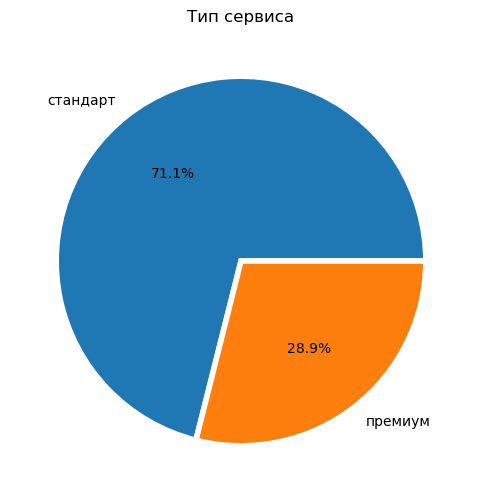

In [50]:
# строим круговую диаграмму
pie(market_type_service, 'Тип сервиса')

На маркете преобладают пользователи со стандартным уровнем.

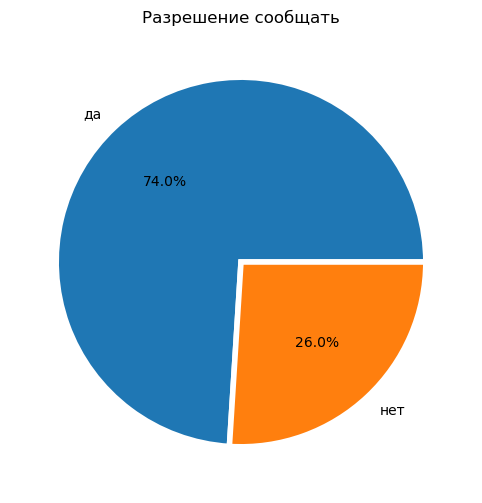

In [51]:
# строим круговую диаграмму
pie(market_reporting, 'Разрешение сообщать')

В маркете `74%` пользователей разрешила присылать покупателю дополнительные предложения о товаре.

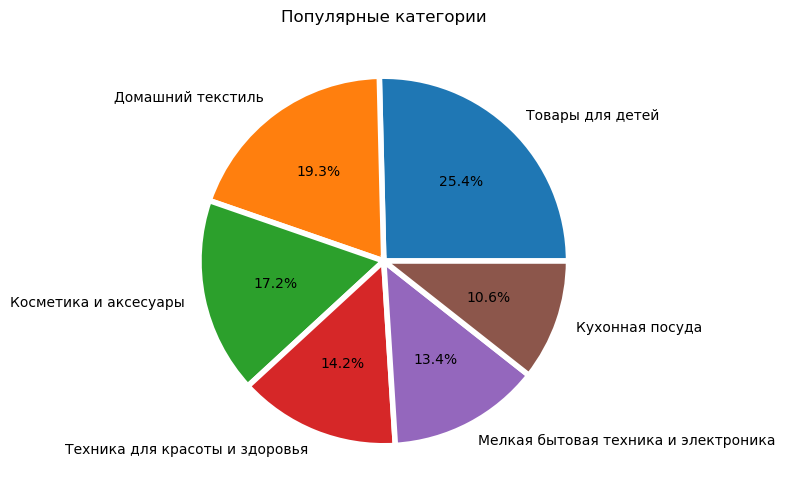

In [52]:
# строим круговую диаграмму
pie(market_popular_cat, 'Популярные категории')

Самая популярная категория на маркете это товары для детей - `25.4%`, наименее популярная - кухонная посудаб, `10.6%`

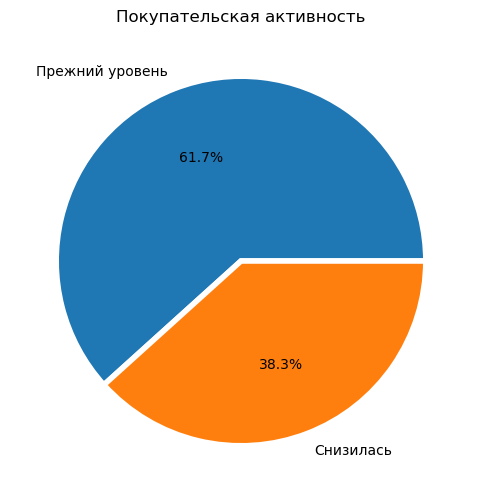

In [53]:
# строим круговую диаграмму
pie(market_buy_activ, 'Покупательская активность')

Среди `61.7%` пользователей маркета сохраниалсь прежняя покупательская ативность.

Изучим количественные переменные в датафрейме и для этого воспользуемся написанной функцийей `boxplot`

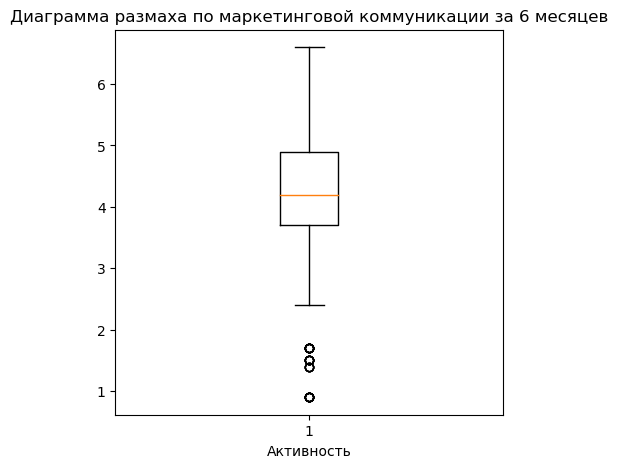

In [55]:
# строим диаграмму размаха
boxplot(market_file['Маркет_актив_6_мес'], 'Диаграмма размаха по маркетинговой коммуникации за 6 месяцев', 'Активность')

Как видно из диаграммы размаха, есть несколько выбросов, но они не являются аномальными, так как просто скорее всего маркентинг компании не был направлен на этих пользователей.

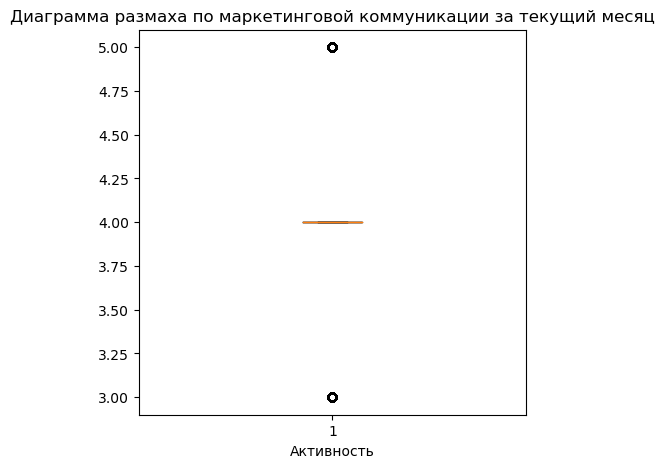

In [56]:
# строим диаграмму размаха
boxplot(market_file['Маркет_актив_тек_мес'], 'Диаграмма размаха по маркетинговой коммуникации за текущий месяц', 'Активность')

Судя по диаграмме и квартили и медиана равняется 4, выведем описательную статистику для этого столбца, чтобы в этом убедится

In [57]:
market_file['Маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

Так и есть, как видно по СКО, то все значения не сильно отклоняются от среднего от сюда и такой результат на графике. Что же касается выбросов, то возможно пользователь, на которого меньше сделали уклон в маркетинге меньше всего был заинтересован в покупках, а верхний выброс, то он возможно больше всех покупал.

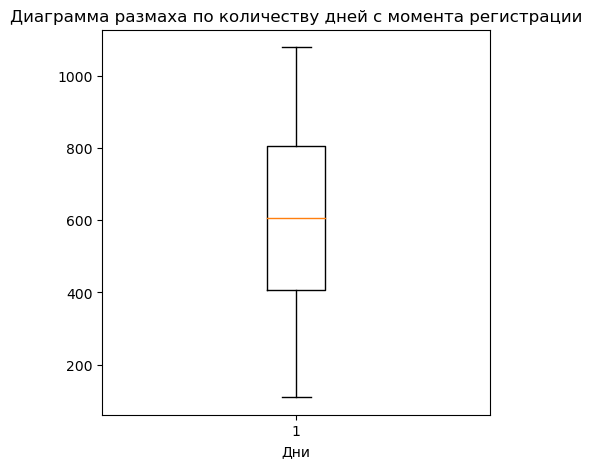

In [58]:
# строим диаграмму размаха
boxplot(market_file['Длительность'], 
        'Диаграмма размаха по количеству дней с момента регистрации', 
        'Дни')

Исходя из диаграммы размаха по количеству дней с момента регистрации выбросов необнаружено.

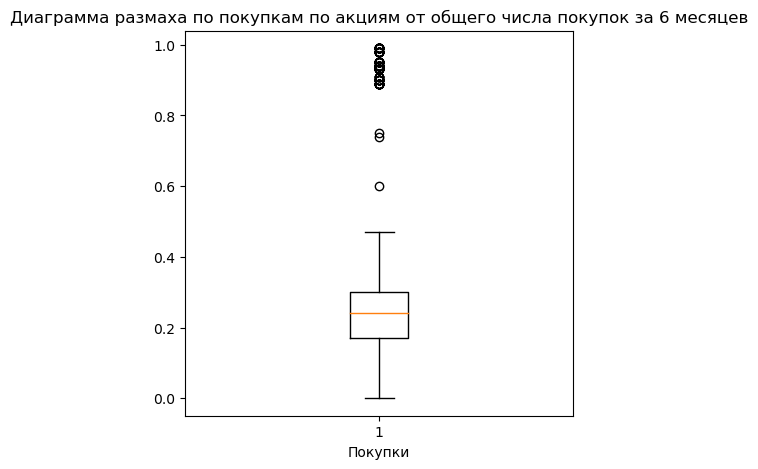

In [59]:
# строим диаграмму размаха
boxplot(market_file['Акционные_покупки'], 
        'Диаграмма размаха по покупкам по акциям от общего числа покупок за 6 месяцев', 
        'Покупки')

Можно заметить, что есть выбросы, но не будем считать их аномальными, так как скорее всего эти пользователи просто чще покупают только по акциям.

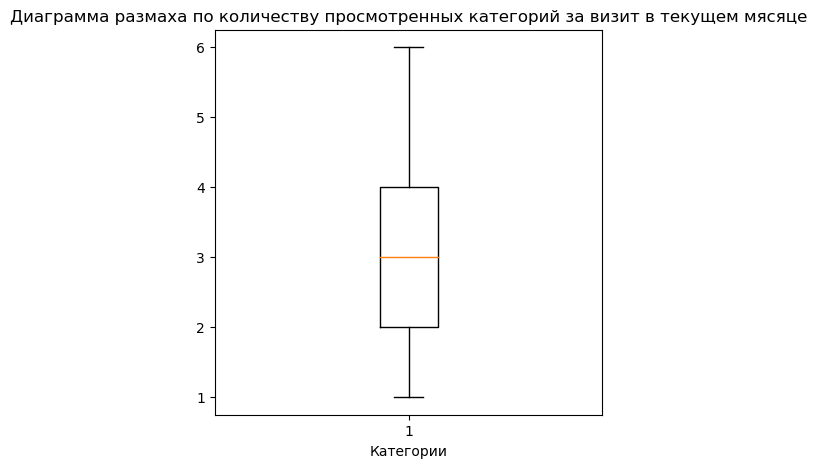

In [60]:
# строим диаграмму размаха
boxplot(market_file['Средний_просмотр_категорий_за_визит'], 
        'Диаграмма размаха по количеству просмотренных категорий за визит в текущем мясяце', 
        'Категории')

Исходя из диаграммы размаха по количеству просмотренных категорий за визит выбросов необнаружено.

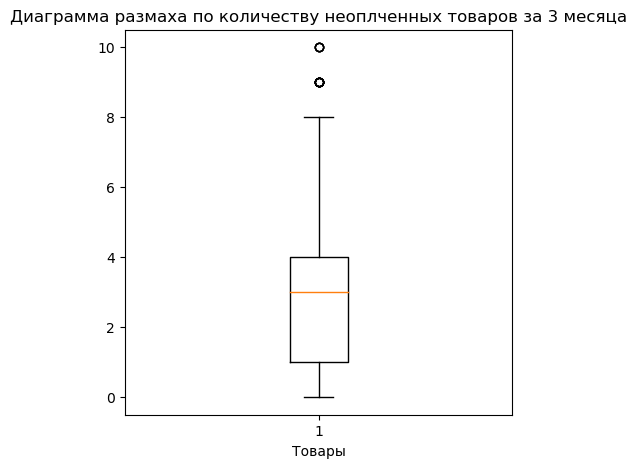

In [61]:
# строим диаграмму размаха
boxplot(market_file['Неоплаченные_продукты_штук_квартал'], 
        'Диаграмма размаха по количеству неоплченных товаров за 3 месяца', 
        'Товары')

Хоть выбросы и обнаружены, пока не будем считать их аномальными, так как возможно эти пользователи часто неоплачивали товар в корзине просто, потому что товар случайно туда попадал или же человек просто так и не решился на покупку.

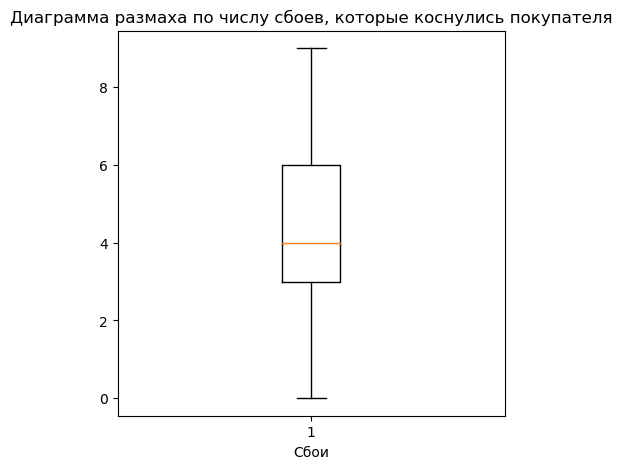

In [62]:
# строим диаграмму размаха
boxplot(market_file['Ошибка_сервиса'], 
        'Диаграмма размаха по числу сбоев, которые коснулись покупателя', 
        'Сбои')

Исходя из диаграммы размаха по числу сбоев выбросов необнаружено.

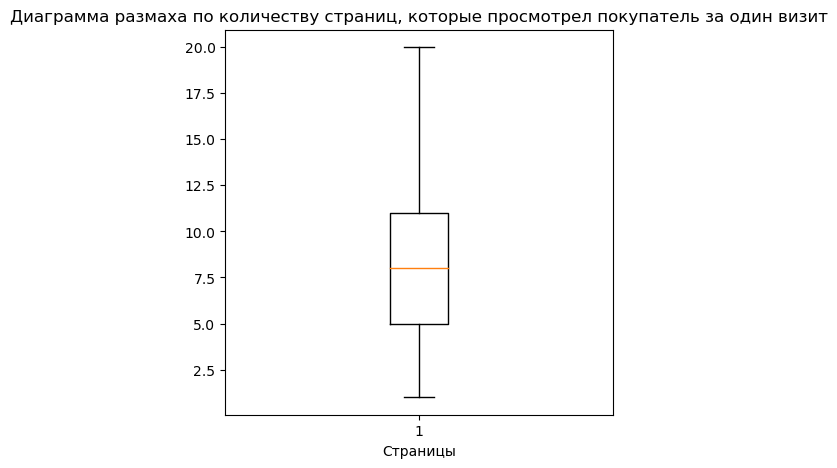

In [63]:
# строим диаграмму размаха
boxplot(market_file['Страниц_за_визит'], 
        'Диаграмма размаха по количеству страниц, которые просмотрел покупатель за один визит', 
        'Страницы')

Исходя из диаграммы размаха по количеству страниц за визит выбросов необнаружено.

Теперь построим гистограммы для каждого колличественного признака. Для этого была написана функиця `displot`.

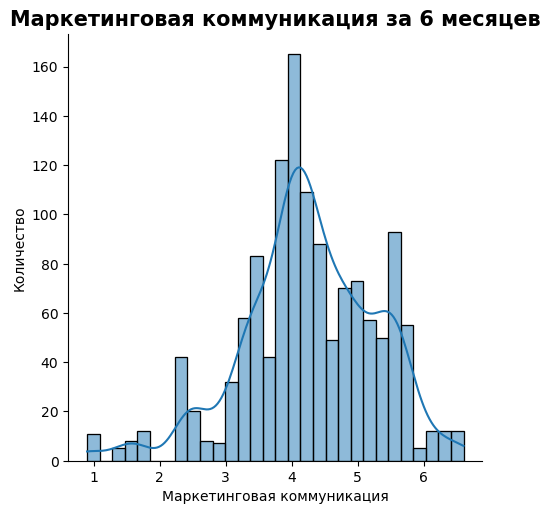

In [65]:
displot(market_file['Маркет_актив_6_мес'], 
        'Маркетинговая коммуникация', 'Количество', 
        'Маркетинговая коммуникация за 6 месяцев', 30)

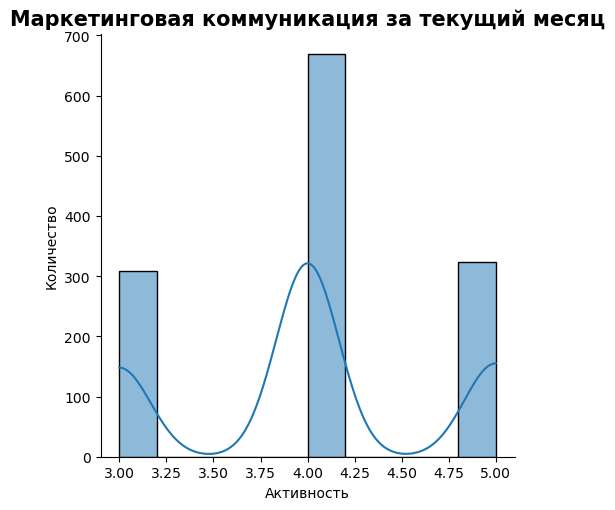

In [66]:
displot(market_file['Маркет_актив_тек_мес'], 'Активность', 'Количество',
        'Маркетинговая коммуникация за текущий месяц', 10)

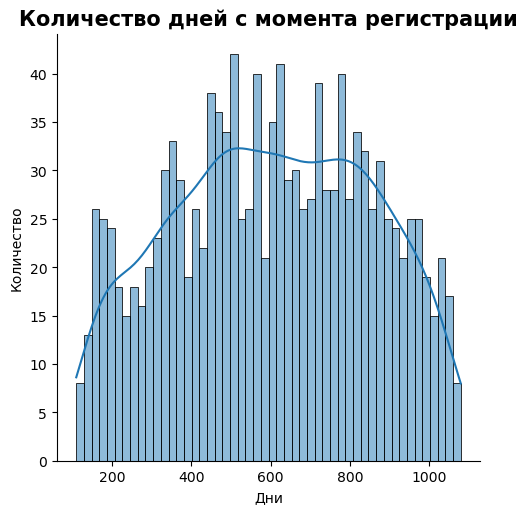

In [67]:
displot(market_file['Длительность'], 'Дни', 'Количество',
        'Количество дней с момента регистрации', 50)

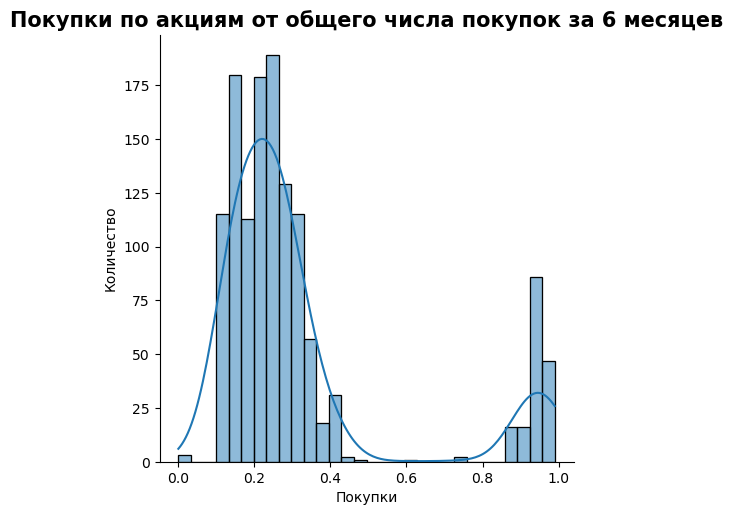

In [68]:
displot(market_file['Акционные_покупки'], 'Покупки', 'Количество',
        'Покупки по акциям от общего числа покупок за 6 месяцев', 30)

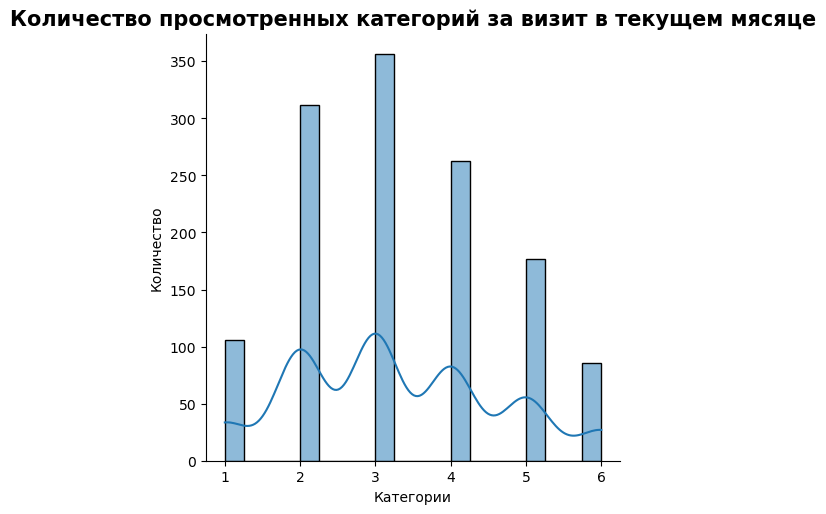

In [69]:
displot(market_file['Средний_просмотр_категорий_за_визит'], 'Категории', 'Количество',
        'Количество просмотренных категорий за визит в текущем мясяце', 20)

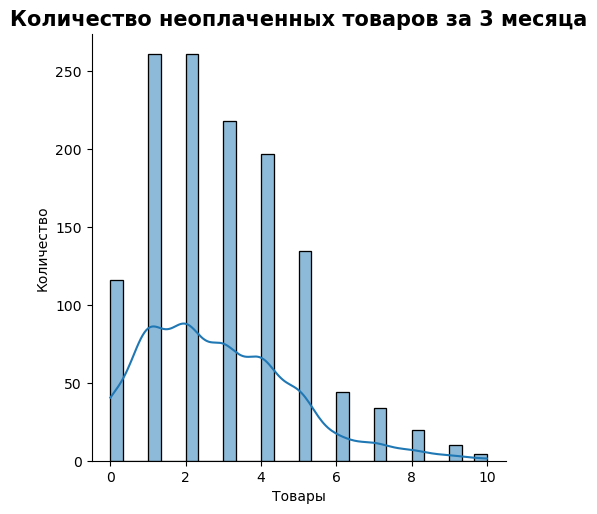

In [70]:
displot(market_file['Неоплаченные_продукты_штук_квартал'], 'Товары', 'Количество',
        'Количество неоплаченных товаров за 3 месяца', 30)

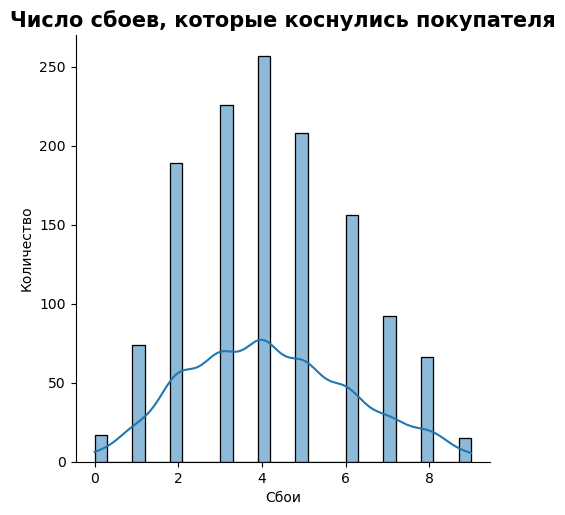

In [71]:
displot(market_file['Ошибка_сервиса'], 'Сбои', 'Количество',
        'Число сбоев, которые коснулись покупателя', 30)

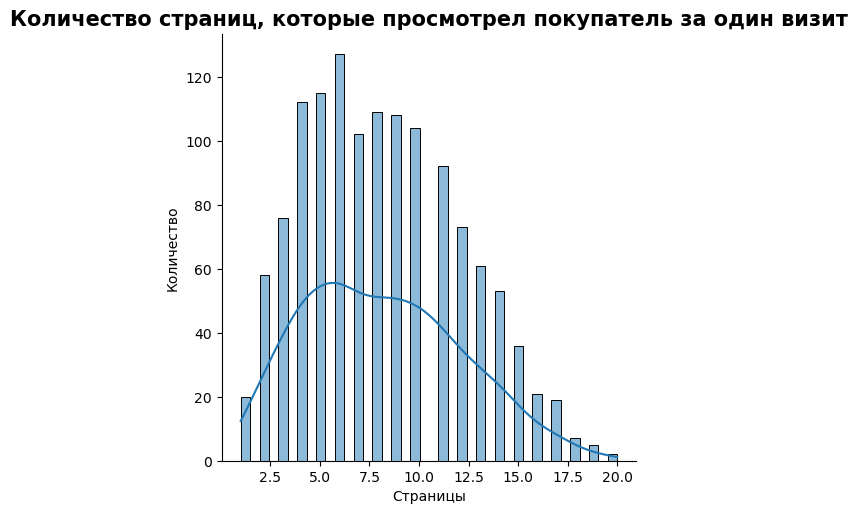

In [72]:
displot(market_file['Страниц_за_визит'], 'Страницы', 'Количество',
        'Количество страниц, которые просмотрел покупатель за один визит', 
        40)

**Вывод**

Судя по гистограммам большинство признаков распределены ненормально.

Теперь создадим два датафрейма, в которых будут хранится данные по уровню сервиса.

In [73]:
market_service_standard = market_file[market_file['Тип_сервиса'] == 'стандарт'] # создаем отдельный датафрейм для стандарта

In [74]:
market_service_premium = market_file[market_file['Тип_сервиса'] == 'премиум'] # создаем отдельный датафрейм для премиума

Изучим данные этих двух датафреймов, выведя их описательную статистику

In [75]:
market_service_standard.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000
mean,216020.696970,4.309848,4.043290,552.841991,0.313279,3.377706,2.773810,4.153680,8.123377
std,370.529169,1.008319,0.685928,239.585270,0.245388,1.385258,1.969905,1.921024,3.939402
min,215350.000000,0.900000,3.000000,110.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,215712.000000,3.800000,4.000000,356.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,216024.500000,4.300000,4.000000,544.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216342.250000,5.000000,5.000000,746.250000,0.300000,4.000000,4.000000,5.000000,11.000000
max,216646.000000,6.600000,5.000000,1064.000000,0.990000,6.000000,10.000000,9.000000,19.000000


In [76]:
market_service_premium.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,215940.494681,4.115957,3.933511,722.452128,0.335851,3.005319,3.002660,4.263298,8.308511
std,381.728623,1.018894,0.718030,233.380097,0.260106,1.241493,1.968415,2.037602,4.074052
min,215348.000000,0.900000,3.000000,121.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,215600.250000,3.500000,3.000000,565.500000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,215910.500000,4.100000,4.000000,763.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216276.750000,4.800000,4.000000,907.250000,0.320000,4.000000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


Несмотря на то, что пользователей премиума меньше их значения практически похожи со стандртным уровнем.

Посмотрим как уровень сервиса зависит от покупательской активности, разрешении сообщать, текушей активности, для этого воспользуемся написанной функцией `bar`.

In [77]:
# группируем по уровню и активности, считаем количество пользователей и сортируем по возрастанию
buy_activ = market_file.groupby(['Тип_сервиса', 'Покупательская_активность'])['id'].count().sort_values()

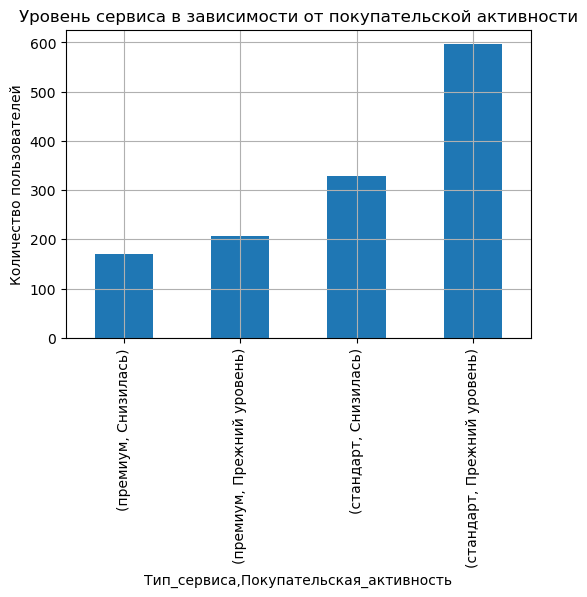

In [78]:
bar(buy_activ, 'Уровень сервиса в зависимости от покупательской активности')

Можно сказать, что у покупательская активность не зависит от уровня сервиса. Что и у премиум пользователей, что и у стандартных преобладает `прежний уровень`.

In [79]:
# группируем по уровню и разрешение, считаем количество пользователей и сортируем по возрастанию
allow_reporting = market_file.groupby(['Тип_сервиса', 'Разрешить_сообщать'])['id'].count().sort_values()

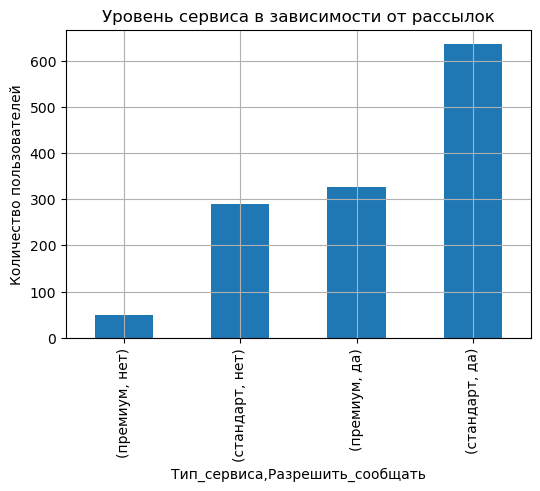

In [80]:
bar(allow_reporting, 'Уровень сервиса в зависимости от рассылок')

Уровень сервиса не зависит от разрешение рассылок.

Приступим к изучению зависимости уровня сервиса от количественых перемен и будем для этого строить гистограмму. Для облегчения построения гистограммы была написана функция `hist` и будем ее применять для всех наших количественных признаков

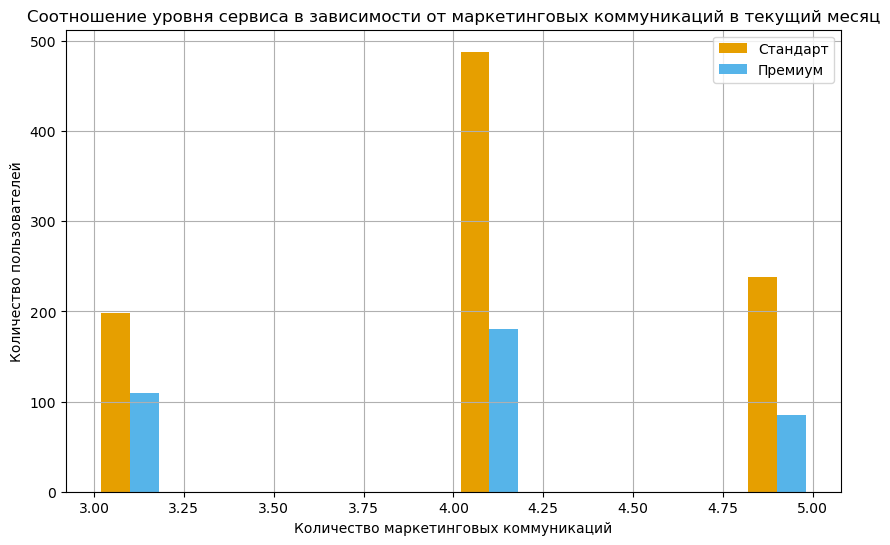

In [81]:
hist(x1=market_service_standard['Маркет_актив_тек_мес'], 
     x2=market_service_premium['Маркет_актив_тек_мес'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество маркетинговых коммуникаций', 
     title='Соотношение уровня сервиса в зависимости от маркетинговых коммуникаций в текущий месяц', 
     bins=10)

Хоть пользователей стандартного уровня больше, можно сказать, что в среднем маркетинг компании направлен на всех клиентов

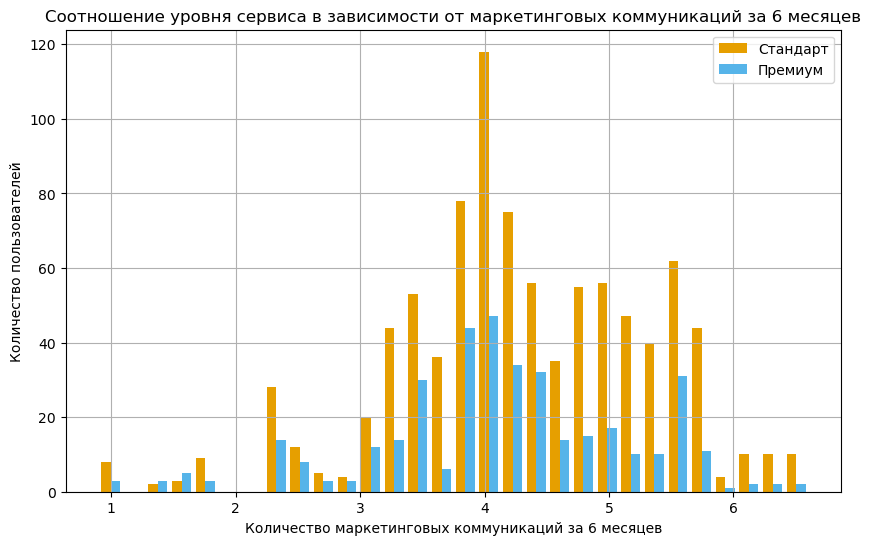

In [82]:
hist(x1=market_service_standard['Маркет_актив_6_мес'], 
     x2=market_service_premium['Маркет_актив_6_мес'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество маркетинговых коммуникаций за 6 месяцев', 
     title='Соотношение уровня сервиса в зависимости от маркетинговых коммуникаций за 6 месяцев', 
     bins=30)

График похож на бимодальное распределение, заметны некоторые выборсы слева, но они не критичны.

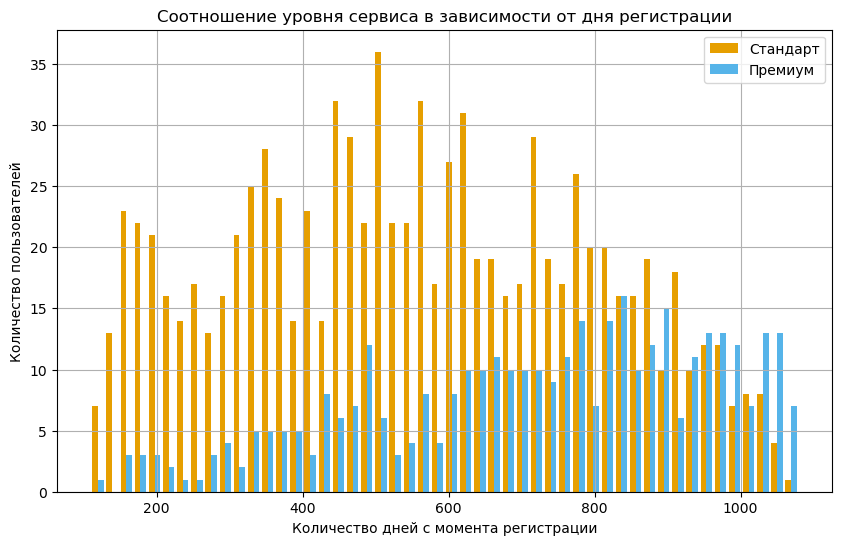

In [83]:
hist(x1=market_service_standard['Длительность'], 
     x2=market_service_premium['Длительность'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество дней с момента регистрации', 
     title='Соотношение уровня сервиса в зависимости от дня регистрации', 
     bins=50)

График имеет непрерывное равномерное распределение. Пользователи, которые уже давно зарегистрировались обычно имеют премиум. 

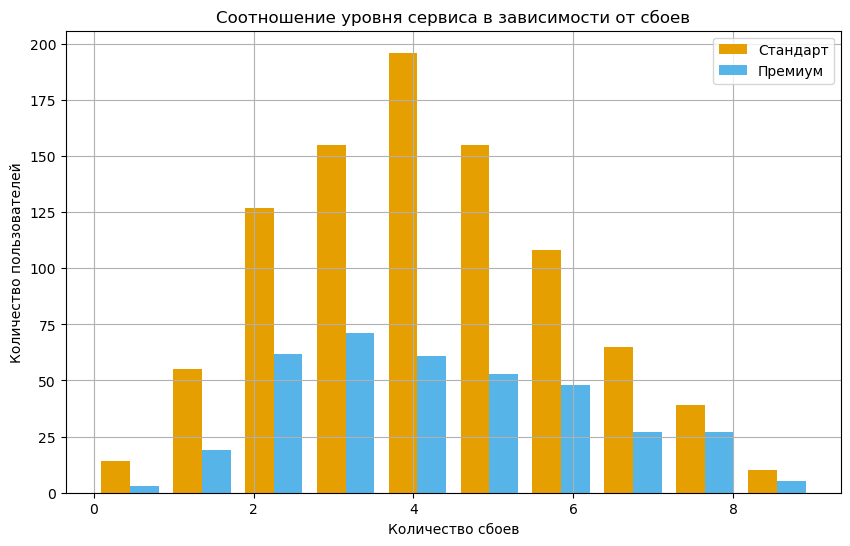

In [84]:
hist(x1=market_service_standard['Ошибка_сервиса'], 
     x2=market_service_premium['Ошибка_сервиса'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество сбоев', 
     title='Соотношение уровня сервиса в зависимости от сбоев', 
     bins=10)

График имеет нормальное распределение смещенное вправо. 

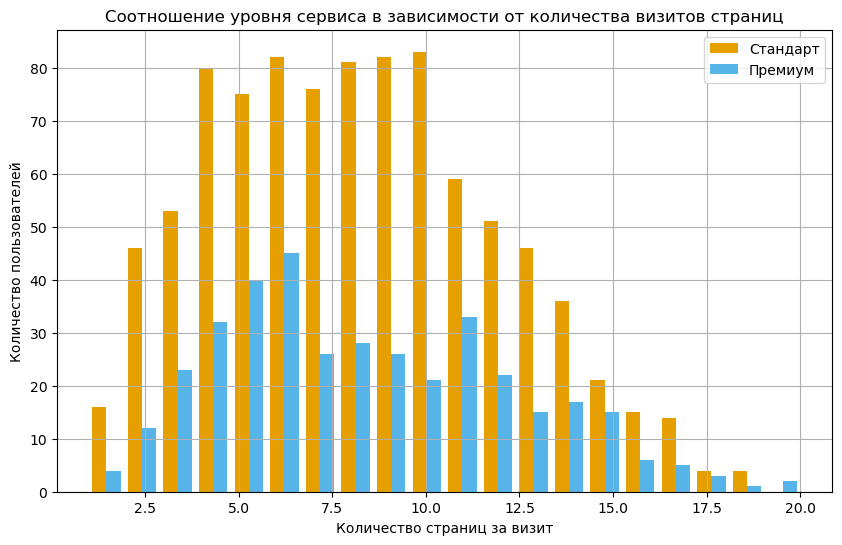

In [85]:
hist(x1=market_service_standard['Страниц_за_визит'], 
     x2=market_service_premium['Страниц_за_визит'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество страниц за визит', 
     title='Соотношение уровня сервиса в зависимости от количества визитов страниц', 
     bins=20)

График имеет нормальное распределение смещенное вправо. Также можно заметить, что большое количество страниц посещают чаще премиум пользователи.

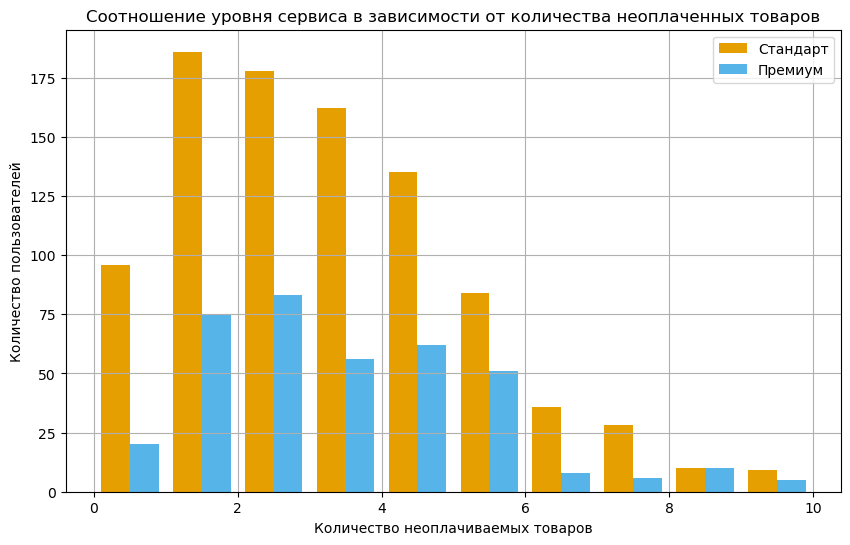

In [86]:
hist(x1=market_service_standard['Неоплаченные_продукты_штук_квартал'], 
     x2=market_service_premium['Неоплаченные_продукты_штук_квартал'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество неоплачиваемых товаров', 
     title='Соотношение уровня сервиса в зависимости от количества неоплаченных товаров', 
     bins=10)

Пользователи стандратного уровня чаще не оплачивает товары, что и логично их просто больше, также можно заметить, что начиная от 8 товаров пользователи уровней сравниваются, что может свидельстовать о том, что премиум пользователи чаще не оплачивают товары.

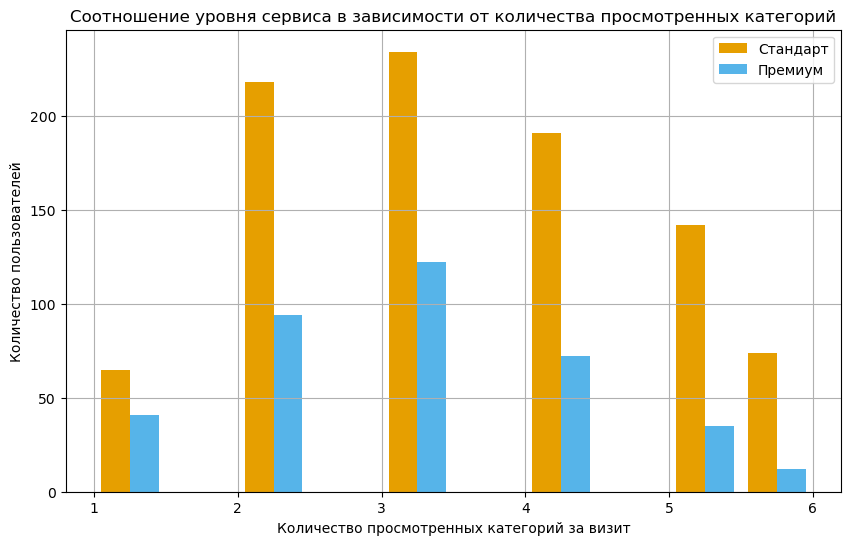

In [87]:
hist(x1=market_service_standard['Средний_просмотр_категорий_за_визит'], 
     x2=market_service_premium['Средний_просмотр_категорий_за_визит'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество просмотренных категорий за визит', 
     title='Соотношение уровня сервиса в зависимости от количества просмотренных категорий', 
     bins=10)

График имеет нормальное распределение. Видно, что премиум пользователи обычно просматривают меньшее количестов категорий, скорее всего связано с тем, что премиум пользователи уже давно пользуются сервисом и поэтому они просматривают только нужные для себя категории, а вот пользователи стандартного уровня чаще просматривают большее количества категорий, что может говорить о том, что это относительно новые пользователи и они смотрят что вообще есть в этом сервисе.

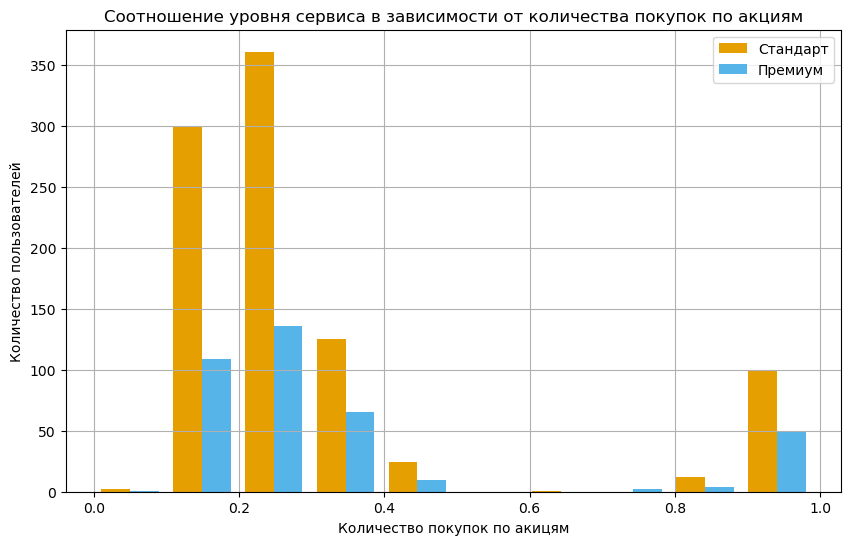

In [88]:
hist(x1=market_service_standard['Акционные_покупки'], 
     x2=market_service_premium['Акционные_покупки'], 
     names = ['Стандарт', 'Премиум'], 
     x_label='Количество покупок по акицям', 
     title='Соотношение уровня сервиса в зависимости от количества покупок по акциям', 
     bins=10)

Пользователи обоих уровней одинаково покупают по акциям.

### Исследуем датафрейм `market_money` для всех клиентов

Приступим к анализу таблицы `market_money` и построим круговые диаграммы, для этого воспользуемся написаной нами функцией `pie`

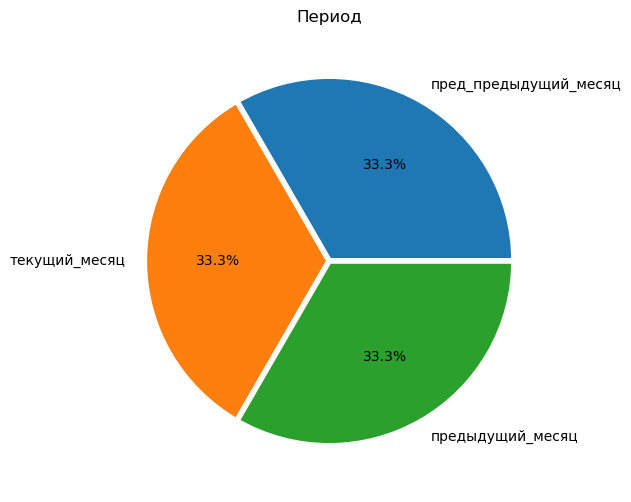

In [89]:
# строим круговую диаграмму
pie(maket_momey_period, 'Период')

За каждый период одинаковое количество информации.

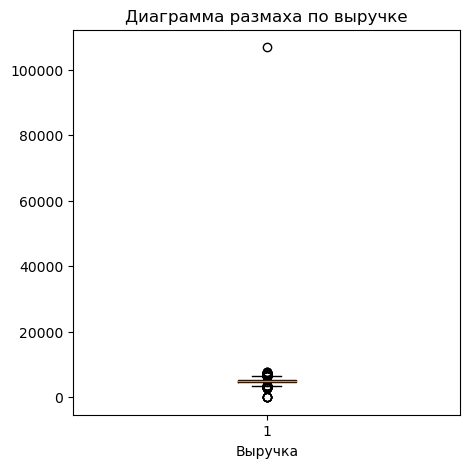

In [90]:
# строим диаграмму размаха
boxplot(market_money['Выручка'], 
        'Диаграмма размаха по выручке', 
        'Выручка')

Есть очень аномально значение, посмотри на него более подробно.

In [91]:
market_money[market_money['Выручка'] > 100000] # смотри на зачение больше 100000

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


У этого клиента очень большая выручка, интересно посмотреть выручку этого клиента за другие приоды, если она есть.

In [92]:
market_money[market_money['id'] == 215380]

,id,Период,Выручка
96,215380,пред_предыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


Видно, что за предыдущие периоды максимальная выручка 6077, так что это значение выглядит аномальным и поэтому его стоит удалить.

In [93]:
market_money = market_money[market_money['Выручка'] < 100000] # удалям аномальное значение

Теперь еще раз построим диаграмму размаха

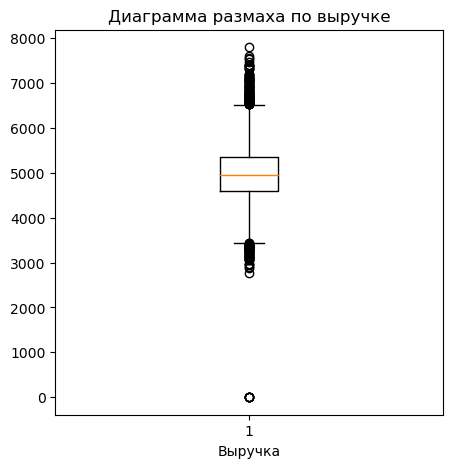

In [94]:
# строим диаграмму размаха
boxplot(market_money['Выручка'], 
        'Диаграмма размаха по выручке', 
        'Выручка')

Видно, что есть много выбросов, но они не являются аномальными, кроме одного самое маленького, также посмотрим на него.

In [95]:
market_money[market_money['Выручка'] < 1000]

,id,Период,Выручка
0,215348,пред_предыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,пред_предыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,пред_предыдущий_месяц,0.0


Таких пользователей оказалось 3 и за два предыдущих периода с них маркет не имел выручки, не будем считать их аномальными, так как клиенты могли и ничего не покупать, а зарегистрировались, для того, чтобы возможно получать интерсные предложение, которые их заинтересуют для покупки, но по условию задачи клиента нам необходимо учитывать активнных пользователей за 3 месяца, поэтому эти данные нам не нужны и мы можем от них избавиться.

In [96]:
market_money = market_money[market_money['Выручка'] > 0] # удалаям не нужные данные

Еще раз построим диаграмму размаха.

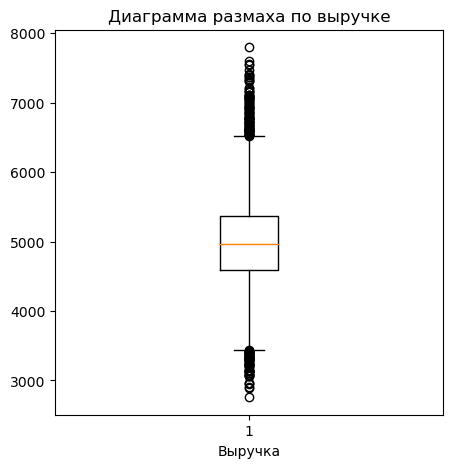

In [97]:
# строим диаграмму размаха
boxplot(market_money['Выручка'], 
        'Диаграмма размаха по выручке', 
        'Выручка')

In [98]:
# группируем по уровню и выручке, считаем количество пользователей и сортируем по возрастанию
period_revenue = market_money.groupby('Период')['Выручка'].sum().sort_values()

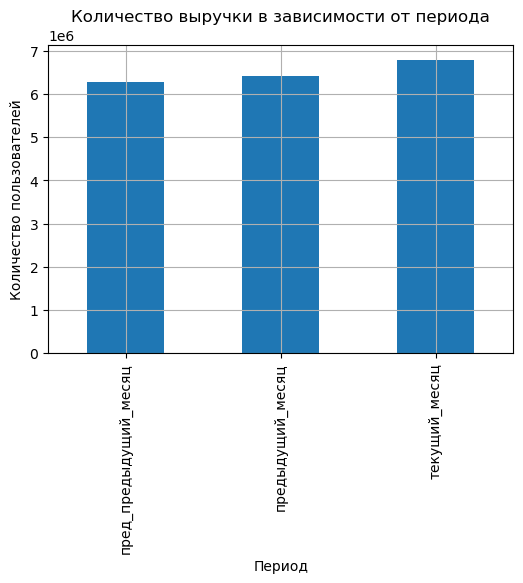

In [99]:
bar(period_revenue, 'Количество выручки в зависимости от периода')

Можно заметить, что выручка с каждым периодом растет.

Построим гистограммы по выручке за каждый период

In [100]:
period_revenue_market = market_money.pivot_table(index='id', columns='Период', values='Выручка')

In [101]:
period_revenue_market.columns = ['пред_предыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

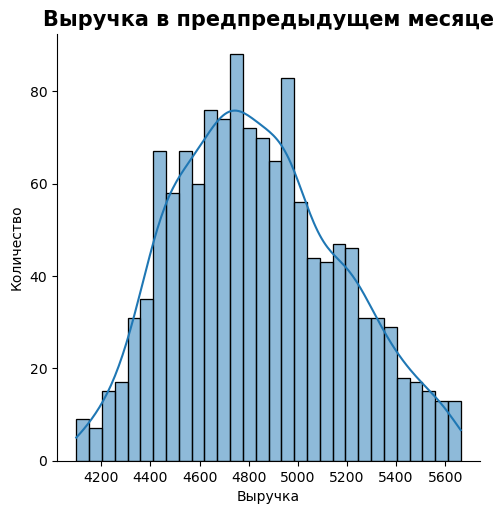

In [102]:
displot(period_revenue_market['пред_предыдущий_месяц'], 'Выручка', 'Количество',
        'Выручка в предпредыдущем месяце', 30)

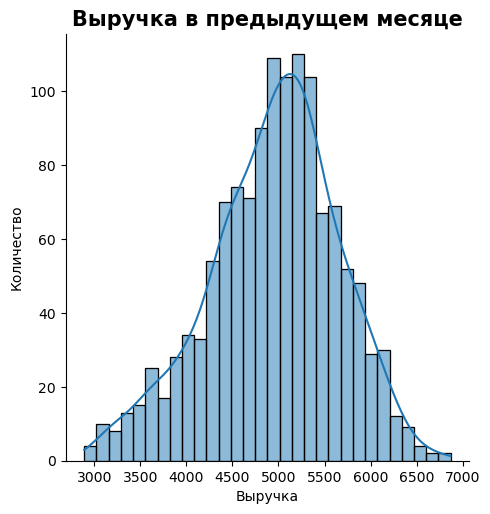

In [103]:
displot(period_revenue_market['предыдущий_месяц'], 'Выручка', 'Количество',
        'Выручка в предыдущем месяце', 30)

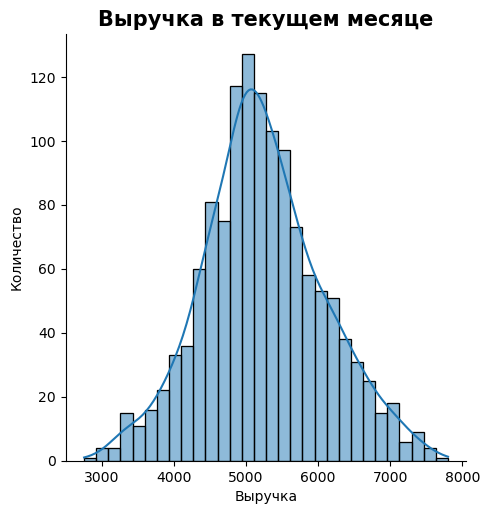

In [104]:
displot(period_revenue_market['текущий_месяц'], 'Выручка', 'Количество',
        'Выручка в текущем месяце', 30)

Судя по графикам, то получаем, что данные распределены нормально по всем 3 месяцам

### Исследуем датафрейм `market_time` для всех клиентов

Приступим к анализу таблицы `market_time` и построим круговые диаграммы, для этого воспользуемся написаной нами функцией `pie`

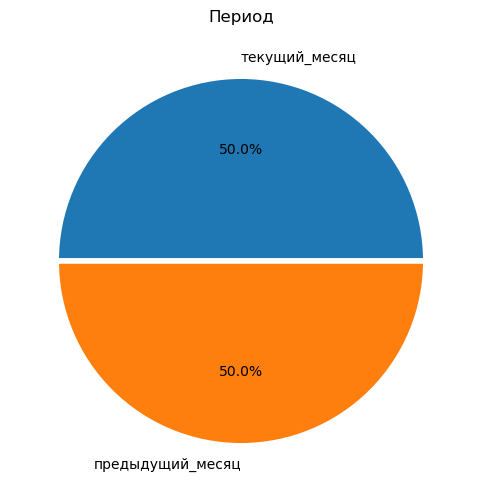

In [105]:
# строим круговую диаграмму
pie(market_time_period, 'Период')

Хранится информация за два последних месяца и соотношение одинаковое.

Изучим количественый столбец данного датафрема с помощью функции `boxplot`

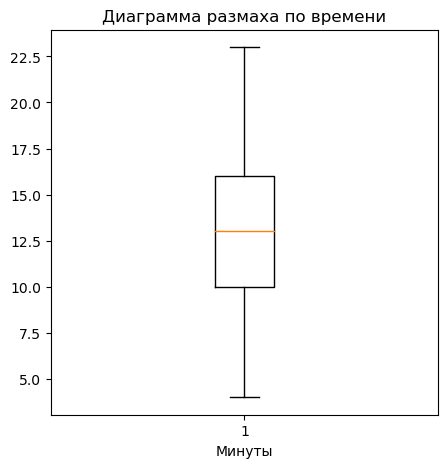

In [106]:
# строим диаграмму размаха
boxplot(market_time['Минут'], 
        'Диаграмма размаха по времени', 
        'Минуты')

Выбросов не было обнаружено

Теперь посмотри на зависимость количества времени проведенной на сайте за каждый период, для этого воспользуемся функцией `displot`

In [109]:
period_minute_market = market_time.pivot_table(index='id', columns='Период', values='Минут')

In [110]:
period_minute_market.columns = ['предыдущий_месяц', 'текущий_месяц']

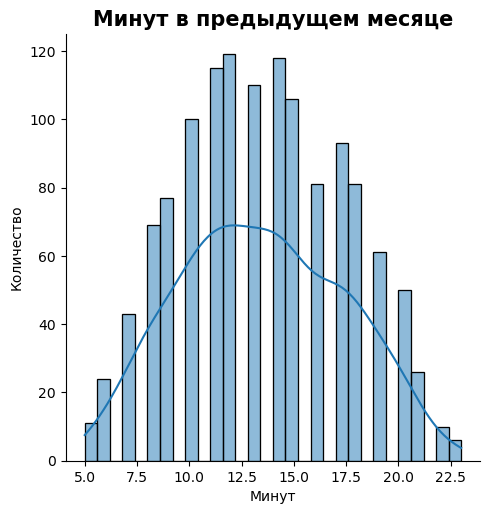

In [111]:
displot(period_minute_market['предыдущий_месяц'], 'Минут', 'Количество',
        'Минут в предыдущем месяце', 30)

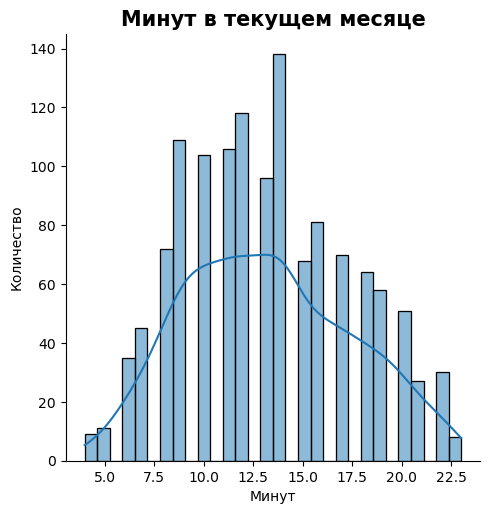

In [112]:
displot(period_minute_market['текущий_месяц'], 'Минут', 'Количество',
        'Минут в текущем месяце', 30)

Оба графика похожи на нормальное распределение.

### Исследуем датафрейм `money` для всех клиентов

Приступим к изучение данных в таблице `money`, и для этого воспользуемся функцие `boxplot`

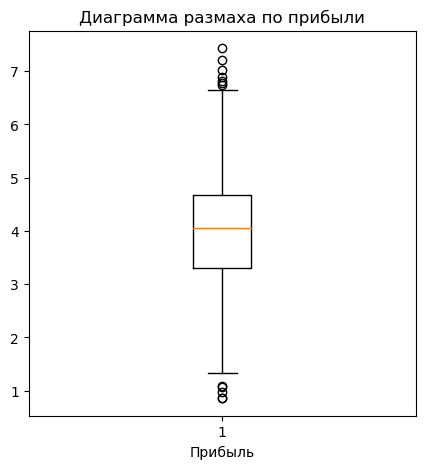

In [113]:
boxplot(money['Прибыль'], 'Диаграмма размаха по прибыли', 'Прибыль')

Выбросы в данном случае не являются аномальными. Посмотрим есть ли в этом датафрейме не активные пользователи, то есть прибыль с них равна нулю.

In [114]:
money[money['Прибыль'] == 0]

,id,Прибыль


Таких пользователей нет, а значит данные только по активным пользователям.

### Вывод

По результатам исследователького анализа можно сделать следующие выводы:

1. На маркете преобладают пользователи со стандартным уровнем `71.1%`.
2. В маркете `74%` разрешила присылать покупателю дополнительные предложения о товаре.
3. Категории на маркете по посещаемости расположились в следующем виде:
    - Товары для детей - `25.4%`.
    - Домашний текстиль - `19.3%`.
    - Косметика и аксесуары - `17.2%.
    - Техника для красоты и здоровья - `14.2`
    - Мелкая бытовая техника и электроника - `13.4%`
    - Кухонная посуда - `10.6%`.
4. Среди `61.7%` пользователей маркета сохраниалсь прежняя покупательская ативность.
5. В таблице `market_file` было найдено несколько выбрсов по количественным переменым, но аномальными они не являются.
6. Несмотря на то, что пользователей премиума меньше их значения практически похожи со стандртным уровнем по описательной статистике.
7. Можно сказать, что у покупательская активность не зависит от уровня сервиса. Что и у премиум пользователей, что и у стандартных преобладает `прежний уровень`.
8. Уровень сервиса не зависит от разрешение рассылок.
9. Хоть пользователей стандартного уровня больше, можно сказать, что в среднем маркетинг компании направлен на всех клиентов.
10. График имеет непрерывное равномерное распределение. Видно, что премиум пользователи уже давно зарегистрировались на маркете от 800 дней и более.
11. График зависимости уровня сервиса от сбоев имеет нормальное распределение смещенное вправо.
12. График зависимости уровня сервиса от посещения страниц имеет нормальное распределение смещенное вправо. Также можно заметить, что большое количество страниц посещают чаще премиум пользователи.
13. Пользователи стандратного уровня чаще не оплачивает товары, что и логично их просто больше, также можно заметить, что начиная от 8 товаров пользователи уровней сравниваются, что может свидельстовать о том, что премиум пользователи чаще не оплачивают товары.
14. Пользователи стандратного уровня чаще не оплачивает товары, что и логично их просто больше, также можно заметить, что начиная от 8 товаров пользователи уровней сравниваются, что может свидельстовать о том, что премиум пользователи чаще не оплачивают товары.
15. Пользователи обоих уровней одинаково покупают по акциям.
16. Информация о выручке за три периода имеет одинаковое количество - `33.3%`.
17. В таблице `market_money` по столбцу выручки было найдено аномальное значение, так как за предыдущие периоды максимальная выручка от пользователя была `6077`, а за текущий `106862.2` при этом это единственое такое крупное значение, поэтому оно было удалено.
18. Посмотрели на пользователей выручка с которых равна нулю. Таких пользователей оказалось 3 и за два предыдущих периода с них маркет не имел выручки,такие клиенты могли ничего не покупать, а зарегистрировались, для того, чтобы возможно получать интерсные предложение, которые их заинтересуют для покупки, но по условию задачи клиента нам необходимо учитывать активнных пользователей за 3 месяца, поэтому эти данные нам не нужны и мы от них избавились.
19. С каждым периодом выручка маркета растет.
20. В таблице `market_time` в столбце с информацией по периодам в процентном соотношении одинаковая - `50%`, так как в данной таблице всего 2 периода.
21. По времени проведенное на сайте текущий период немного уступает предыдущему.
22. В таблице `money` нет аномально больших значений, а также пользователей с нулевой выручкой.

## Объединение данных.

Объединим таблицы `market_file`, `market_money`, `market_time`. При этом необходимо создать отдельный столбец для выручек и минут по каждому из периодов.

In [115]:
market_total = market_file.copy() # делаем копию датафрейма

Создадим три датафрейма из `market_money`, в которых будет хранится выручка по периодам.

In [116]:
market_pred_pred_period = (
    market_money[market_money['Период'] == 'пред_предыдущий_месяц']
    .rename(columns={'Выручка':'Выручка_пред_предыдущий_месяц'})
    [['id', 'Выручка_пред_предыдущий_месяц']]
)

In [117]:
market_pred_period = (
    market_money[market_money['Период'] == 'предыдущий_месяц']
    .rename(columns={'Выручка':'Выручка_предыдущий_месяц'})
    [['id', 'Выручка_предыдущий_месяц']]
)

In [118]:
market_period = (
    market_money[market_money['Период'] == 'текущий_месяц']
    .rename(columns={'Выручка':'Выручка_текущий_месяц'})
    [['id', 'Выручка_текущий_месяц']]
)

Объединим созданные датафреймы с датафеймом `market_total`.

In [119]:
market_total = market_total.merge(market_period, on='id', how='inner')

In [120]:
market_total = market_total.merge(market_pred_period, on='id', how='inner')

In [121]:
market_total = market_total.merge(market_pred_pred_period, on='id', how='inner')

Создадим три датафрейма из `market_time`, в которых будет хранится минуты на сайте по периодам.

In [122]:
market_time_pred_period = (
    market_time[market_time['Период'] == 'предыдущий_месяц']
    .rename(columns={'Минут':'Минут_предыдущий_месяц'})
    [['id', 'Минут_предыдущий_месяц']]
)

In [123]:
market_time_period = (
    market_time[market_time['Период'] == 'текущий_месяц']
    .rename(columns={'Минут':'Минут_текущий_месяц'})
    [['id', 'Минут_текущий_месяц']]
)

Объединим созданные датафреймы с датафеймом `market_total`.

In [124]:
market_total = market_total.merge(market_time_pred_period, on='id', how='inner')

In [125]:
market_total = market_total.merge(market_time_period, on='id', how='inner')

Выведем первые 5 строк датафрейма основного. Также можно отметить, что некоторых нет в основном датафрейме, это связано с тем, что они не совершали покупки за последние 3 месяца.

In [126]:
market_total.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_пред_предыдущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


## Корреляционный анализ.

Исходя из исследовательского анализа стало понятно, что данные в нашем датафреме распределены не нормально, поэтому для изучения взаимосвязи между переменнами в таблице `market_total` необходимо использовать коэффициент корреляции Фи, он может находить взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

Расчитаем корреляцию при помощи библиотеки Фик для всех наших признаков

In [163]:
phik_matrix = market_total.drop(columns='id').phik_matrix() # расчитываем коэффициент корреляции Фи

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_пред_предыдущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц']


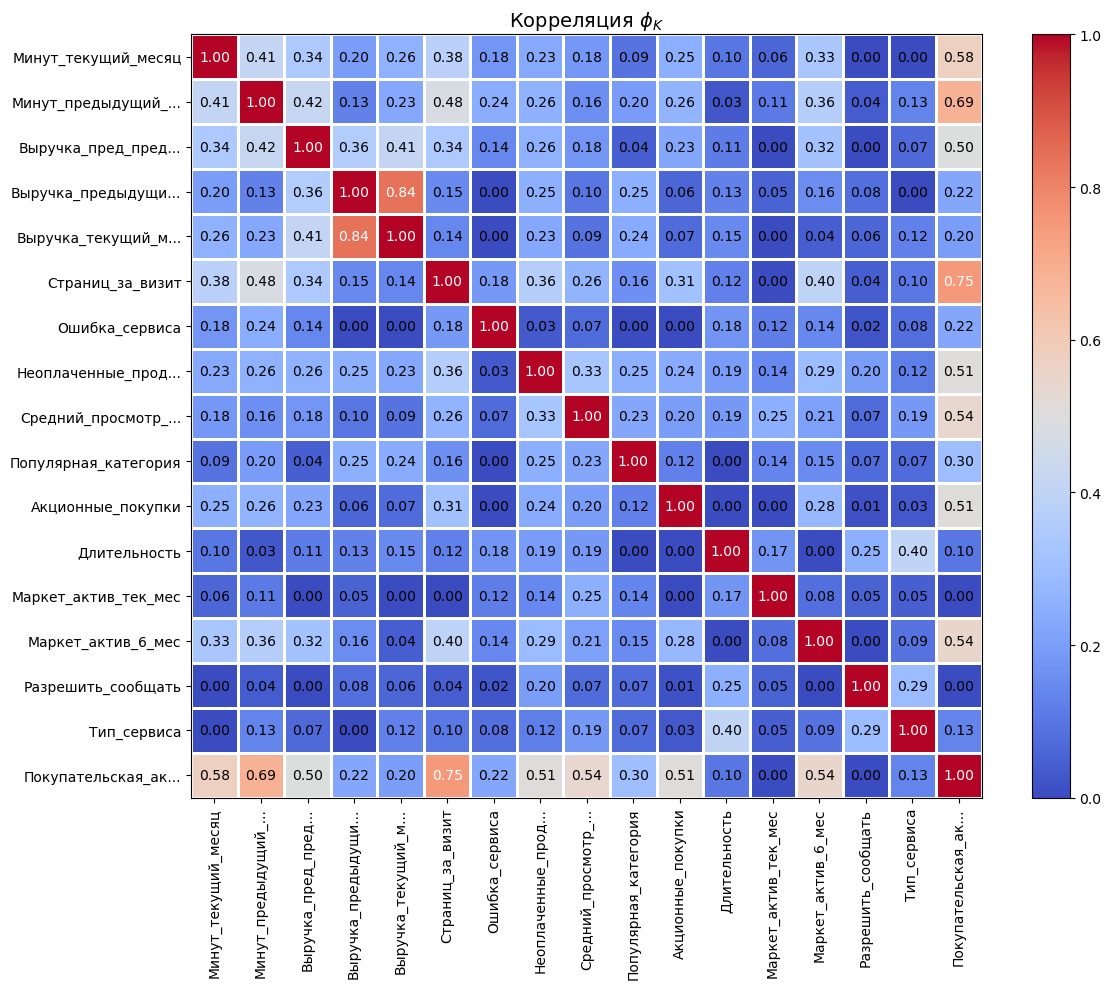

In [164]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_K$', fontsize_factor=1,
                        figsize=(12,10))
plt.tight_layout()

Нашем целевым признаком является `Покупательская активность` посмотрим, как она взаимодействует с другими признаками.

1. Наш целевой признак имеет сильную вазимосвязь с признаками `Страниц_за_визит` = 0.75 и `Минут_предыдущий_месяц` = 0.69.
2. С признаками `Минут_текущий_месяц`, `Выручка_пред_предыдущий_месяц`, `Неоплаченные_продукты_штук_квартал`, `Средний_просмотр_категорий_за_визит`, `Акицонные_покупки` и `Маркет_актив_6_мес` имеется хорошая взаимосвязь.
3. С признаками `Тип_сервиса`, `Длительность`, `Ошибка_сервиса`, `Выручка_текущий_месяц`, `Выручка_предыдущий_месяц` и `Популярная_категория` целевой признак имеет слабвую взаимосвязь.
4. С признаками `Маркет_актив_тек_мес` и `Разрешить_сообщать` целевой признак не имеет взаимосвязи.

Мультиколлинеарность между входными признаками не наблюдается

## Обучение модели.

Приступим к обучению модели. Наш целевой признак - `Покупательская активность`. Для этого воспользуемся 4 моделями `LogisticRegression`, `SVC`, `KNeighborsClassifier` и `DecisionTreeClassifier` и для них будет подбирать гиперпараметры при помощи `RandomizedSeachCV` и выведем параметры лучшей модели. Оценивать модель будем по метрике `ROC-AUC`, так как эта метрика классификации учитывает работу модели при всех возможных значениях порогов в отличие от других.

P.S.Не использую второй раз `SimpleImputer` в ord, потому что у меня появляется ошибка `cannot pickle 'module' object` и я так и не понял из-за чего.

In [130]:
X = market_total.drop(columns=['Покупательская_активность', 'id'], axis=1)
y = market_total['Покупательская_активность']

# разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# создаём списки с названиями признаков
ohe_columns = ['Тип_сервиса', 'Разрешить_сообщать']
ord_columns = ['Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса',
               'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_предыдущий_месяц', 
               'Выручка_пред_предыдущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))]
)

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[['Кухонная посуда', 'Мелкая бытовая техника и электроника',
                     'Техника для красоты и здоровья', 'Косметика и аксесуары',
                     'Домашний текстиль', 'Товары для детей']], 
        handle_unknown='use_encoded_value', unknown_value=-1))]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

y_test_pred = randomized_search.predict_proba(X_test)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                            

C:\Users\stepa\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


В результате получаем, что лучшая модель это `LogisticRegression` с параметрам `C = 4` этот параметр отвечает за силу регуляризации, то есть, чтобы избежать переобучения модели. Как видно из метрики на тестовых данных модель показала себе чуточку лучше, но в целом результат одинаковый, а значит модель не переобучилась.

## Анализ важности признаков.

Посмотрим на вклад признака в каждый прогноз при помощи значений Шепли

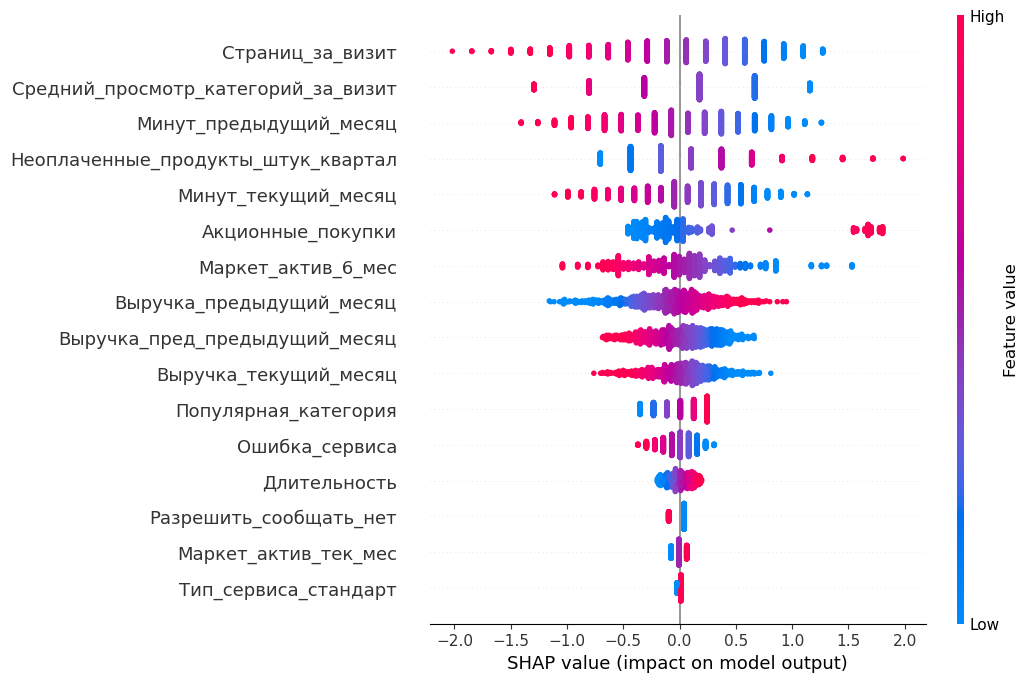

In [161]:
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values, max_display=18) 

Интерпритируем результаты:
1. Чем больше значения признаков `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `Минут_предыдущий месяц`, `Минут_текущий_месяц`, `Маркет_актив_6_мес`, `Выручка_пред_предыдущий_месяц`, `Выручка_текущий_месяц` тем выше SHAP значение, то есть если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежать к класу 0, то есть покупательская осталась на прежнем уровне.
2. Чем больше значение признаков `Неоплаченные_продукты_штук_квартал`, `Акционные_покупки`, `Выручка_предыдущий_месяц` тем выше вероятность наблюдения принадлежать к классу 1, то есть покупательская активность снизится.

Построим диаграмму, которая отражает общий вклад признаков в прогнозы модели.

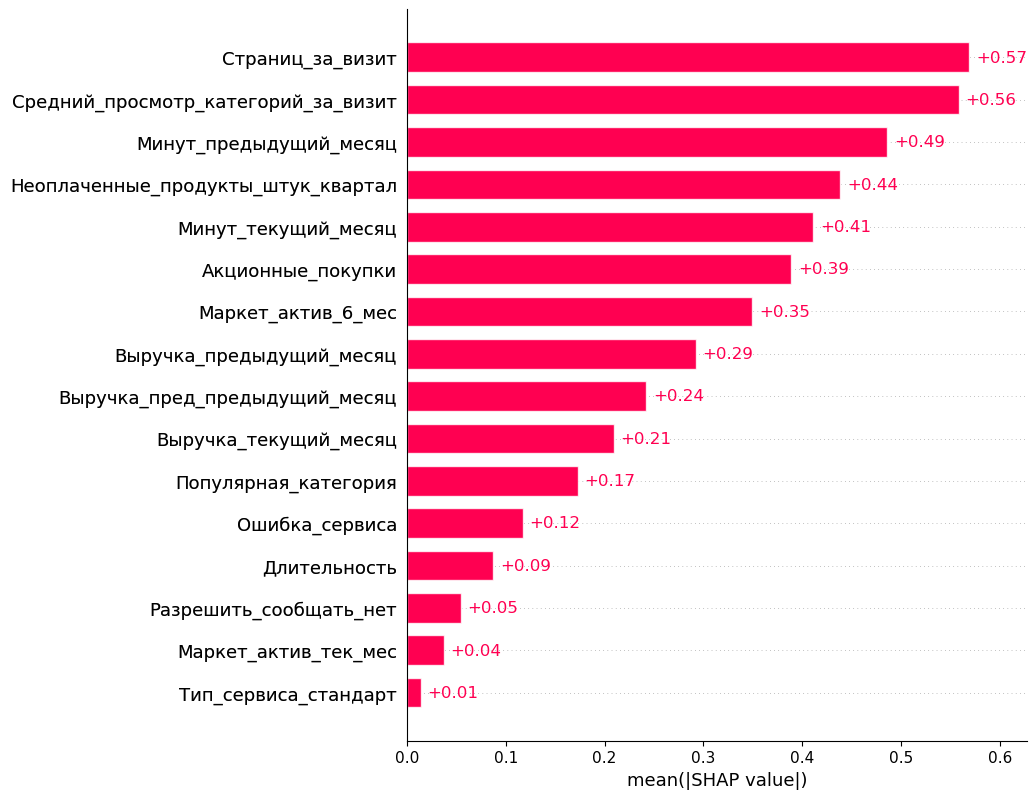

In [158]:
shap.plots.bar(shap_values, max_display=18)

Интерпритируем результаты:
1. Чем больше значения признаков `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `Минут_предыдущий месяц`, `Минут_текущий_месяц`, `Маркет_актив_6_мес`, `Выручка_пред_предыдущий_месяц`, `Выручка_текущий_месяц` тем выше SHAP значение, то есть если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежать к класу 0, то есть покупательская осталась на прежнем уровне.
2. Чем больше значение признаков `Неоплаченные_продукты_штук_квартал`, `Акционные_покупки`, `Выручка_предыдущий_месяц` тем выше вероятность наблюдения принадлежать к классу 1, то есть покупательская активность снизится.

С точки зрения модели мало значимыми признаками являются `Тип_сервиса`, `Маркет_актив_тек_мес`, `Разрешить сообщать`, `Длительность`. 

С точки зрения модели наиболее важные признаки, которые влияют на покупательскую активность: `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `Минут_предыдущий_месяц`, `Неоплаченные_продукты_штук_месяц` и `Минут_текущий_месяц`. Между этими признаками существуют взаимосвязи, которые модель смогла выявить.

## Сегментация покупателей.

Выделим главный сегмент, в котором будут пользователи с высокой вероятностью снижения покупательской активности, чтобы в дальнейшем работать только с этими пользователями.

Объединим датафреймы `market_total` и `money` и из него выделим сегмент.

In [134]:
market_total_segment = market_total.merge(money, on='id', how='inner')

In [135]:
segment_user_total = (
    market_total_segment[(market_total_segment['Страниц_за_визит'] < 6) 
                         & (market_total_segment['Средний_просмотр_категорий_за_визит'] < 8) 
                         & (market_total_segment['Минут_предыдущий_месяц'] < 13) 
                         & (market_total_segment['Неоплаченные_продукты_штук_квартал'] > 2)
                         & (market_total_segment['Минут_текущий_месяц'] < 13)]
)

Выделим сегмент пользователей, которые покупают только технику.

In [136]:
segment_technique = (
    segment_user_total[(segment_user_total['Популярная_категория'] == 'Техника для красоты и здоровья')
                       | (segment_user_total['Популярная_категория'] == 'Мелкая бытовая техника и электроника')]
)

Выделим сегмент пользователей с максимальной долей покупок по акции.

In [137]:
segment_promotional = segment_user_total[segment_user_total['Акционные_покупки'] > 0.7]

Выделим сегмент пользователей, которые покупают товары из категории `Товары для детей`.

In [138]:
segment_product_child = segment_user_total[segment_user_total['Популярная_категория'] == 'Товары для детей']

### Изучим сегмент, который покупает технику

In [139]:
segment_technique.shape

(15, 19)

In [140]:
segment_technique['Маркет_актив_6_мес'].median()

3.5

Посчитаем среднюю прибыль с этого сегмента, чтобы сравнить его с другими и понять на какой сегмент стоит сделать упор в начале.

In [141]:
segment_technique['Прибыль'].mean()

4.177333333333333

В данной категори 15 пользователей, в среднем маркетинговых коммуникаций 3.5 за каждый месяц, средняя прибыль с сегмента 4.2

Так как есть два вида техники, то посмотрим какую чаще покупают

In [142]:
bar_tech = segment_technique.groupby('Популярная_категория')['id'].count()

Text(0.5, 1.0, 'Категории техники')

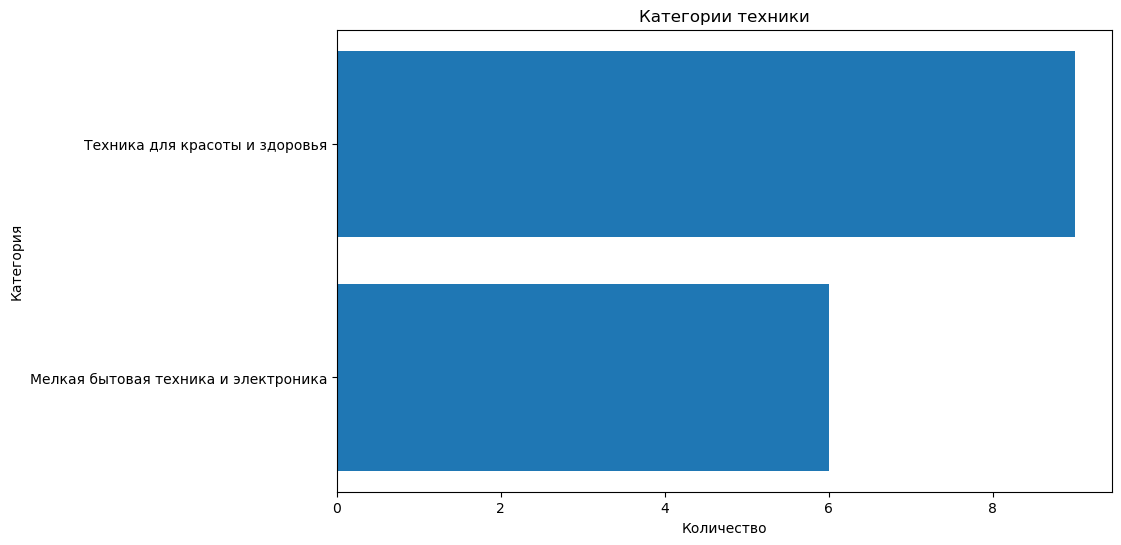

In [143]:
plt.figure(figsize=(10, 6))
plt.barh(bar_tech.index, bar_tech)
plt.xlabel('Количество')
plt.ylabel('Категория')
plt.title('Категории техники')

Более популярная техника для здоровья и красоты. Людей в данной категории немного, что возможно говорит, о том, что довольно выборочно подходят к покупке техники и соотвестно редко покупают. Как вариант, стоит предлагать подборки по той технике, которую они приобрели это может их заинтересовать.

### Изучим сегмент с максимальной долей покупок по акциям

In [144]:
segment_promotional.shape

(48, 19)

In [145]:
segment_promotional['Прибыль'].mean()

3.783333333333333

In [146]:
segment_promotional['Маркет_актив_6_мес'].median()

3.7

В данной категори 48 пользователей, в среднем маркетинговых коммуникаций 3.7 за каждый месяц, средняя прибыль с сегмента 3.8

Посмотрим в каких категориях чаще покупают по акциям

In [147]:
bar = segment_promotional.groupby('Популярная_категория')['id'].count()

Text(0.5, 1.0, 'Категории с максимальной долей покупок по акциям')

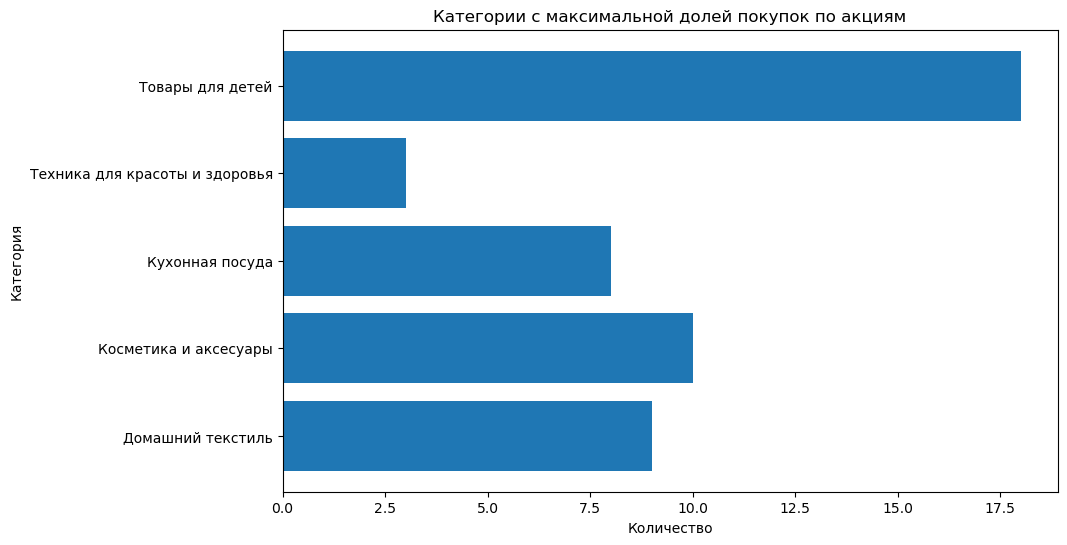

In [148]:
plt.figure(figsize=(10, 6))
plt.barh(bar.index, bar)
plt.xlabel('Количество')
plt.ylabel('Категория')
plt.title('Категории с максимальной долей покупок по акциям')

Возможно стоит чаще направлять на таких пользователей маркетинговую коммуникацию и стараться предлагать им товары по акциям, но по их любимым категориям, обычно это категория - товары для детей.

### Изучим сегмент - покупают товары из категории `Товары для детей`

In [149]:
segment_product_child.shape

(42, 19)

In [150]:
segment_product_child['Акционные_покупки'].median()

0.39

In [151]:
segment_product_child['Прибыль'].mean()

3.968809523809523

In [152]:
segment_product_child['Маркет_актив_6_мес'].median()

4.0

Посмотрим сколько минут эти пользователи тратили в месяц в среднем и сравним их с временм всех пользователей

In [153]:
segment_product_child['Минут_предыдущий_месяц'].median()

9.0

In [154]:
market_total['Минут_предыдущий_месяц'].median()

13.0

Пользователи меньше времени тратят на использование сервиса, оно и логично у них покупательская активность снизится, так как им требуются товары для детей, то следуем им рекомендовать именно их и что-то из смежных категория, так как у скорее всего у них мало времени, чтобы самим искать товары, так как они заняты, работой, детьми и т.п.
На них также не особо будет влиять скидки на товары, их основное снижение из-за того, что у них нет времени, изучать ассортимент магазина.

## Общий вывод.

Данные были получены из четырех файлов:
- `/datasets/market_file.csv`;
- `/datasets/market_money.csv`;
- `/datasets/market_time.csv`;
- `/datasets/money.csv`.

Сначала был сделан обзор данных. Само исследование проходило в семь этапов:
- Изучить данные;
- Предаброботка данных;
- Исследовательский анализ данных;
- Корреляционный анализ;
- Обучение модели;
- Анализ важности признаков;
- Сегментация покупателей.

**1. Обзор данных.**

В таблице `money` данные склеились из-за неправильного разделителя 

- В таблице `market_file` - 13 столбцов, тип данных - `int`(7), `object`(4), `float`(2). Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбцов `Покупательская активность`, `Тип сервиса`, `Разрешить сообщать` не соотвествует стилю.
  
- В таблице `market_money` - 3 столбца, тип данных - `int`(1), `object`(1), `float`(1). Пропусков нет. Название столбцов соотвествует стилю.

- В таблице `market_time` - 3 столбца, тип данных - `int`(2), `object`(1). Пропусков нет. В столбце `минут` сделали первую букву прописной для единого стиля всех таблиц

- В таблице `money` - 2 столбца, тип данных - `int`(1), `object`(1). Пропусков нет. Название столбцов соотвествует стилю. В столбце `Прибыль` сменили тип данных на `float`.

**2. Прелаброботка данных.**

Переименовали столбцы в датафреймах:
- Переименовали столбцы в таблице `market_file`:

    - `Покупательская активность` на `Покупательская_активность`,
    - `Тип сервиса` на `Тип_сервиса`,
    - `Разрешить сообщать` на `Разрешить_сообщать`.

- Переимновали столбец в таблице `market_time`:

    - `минут` на `Минут`.

Сделали провреку на пропуски - **не обнаружены**.

Сделали проверку на явные дубликаты - **не обнаружены**.

- Сделали проверку на неявные дубликаты:
    - В таблице `market_file` в столбце `Тип_сервиса` заменили `стандартт` на `стандарт`;
    - В таблице `market_money` в столбце `Период` исправили ошибку написания `препредыдущий_месяц` на `пред_предыдущий_месяц`;
    - В таблице `market_time` в столбце `Период` исправили ошибку написания `предыдцщий_месяц` на `предыдущий_месяц`.

Проверили типы данных в датафреймах:
   - Изменили тип данных в таблице `money` в столбце `Прибыль` с `object` на `float`.
   
**3. Исследовательский анализ данных.**

1. На маркете преобладают пользователи со стандартным уровнем `71.1%`.
2. В маркете `74%` пользователей разрешила присылать покупателю дополнительные предложения о товаре.
3. Категории на маркете по посещаемости расположились в следующем виде:
    - Товары для детей - `25.4%`.
    - Домашний текстиль - `19.3%`.
    - Косметика и аксесуары - `17.2%.
    - Техника для красоты и здоровья - `14.2`
    - Мелкая бытовая техника и электроника - `13.4%`
    - Кухонная посуда - `10.6%`.
4. Среди `61.7%` пользователей маркета сохраниалсь прежняя покупательская ативность.
5. В таблице `market_file` было найдено несколько выбрсов по количественным переменым, но аномальными они не являются.
6. Несмотря на то, что пользователей премиума меньше их значения практически похожи со стандртным уровнем по описательной статистике.
7. Можно сказать, что покупательская активность не зависит от уровня сервиса. Что и у премиум пользователей, что и у стандартных преобладает `прежний уровень`.
8. Уровень сервиса не зависит от разрешение рассылок.
9. Хоть пользователей стандартного уровня больше, можно сказать, что в среднем маркетинг компании направлен на всех клиентов.
10. График зависимости уровня сервиса от длительности имеет непрерывное равномерное распределение. Видно, что премиум пользователи уже давно зарегистрировались на маркете от 800 дней и более.
11. График зависимости уровня сервиса от сбоев имеет нормальное распределение смещенное вправо.
12. График зависимости уровня сервиса от посещения страниц имеет нормальное распределение смещенное вправо. Также можно заметить, что большое количество страниц посещают чаще премиум пользователи.
13. Пользователи стандратного уровня чаще не оплачивает товары, что и логично их просто больше, также можно заметить, что начиная от 8 товаров пользователи уровней сравниваются, что может свидельстовать о том, что премиум пользователи чаще не оплачивают товары.
14. Пользователи обоих уровней одинаково покупают по акциям.
15. Информация о выручке за три периода имеет одинаковое количество - `33.3%`.
16. В таблице `market_money` по столбцу выручки было найдено аномальное значение, так как за предыдущие периоды максимальная выручка от пользователя была `6077`, а за текущий `106862.2` при этом это единственое такое крупное значение, поэтому оно было удалено.
17. Посмотрели на пользователей выручка с которых равна нулю. Таких пользователей оказалось 3 и за два предыдущих периода с них маркет не имел выручки,такие клиенты могли ничего не покупать, а зарегистрировались, для того, чтобы возможно получать интерсные предложение, которые их заинтересуют для покупки, но по условию задачи клиента эти данные нам не нужны.
18. С каждым периодом выручка маркета растет.
19. В таблице `market_time` в столбце с информацией по периодам в процентном соотношении одинаковая - `50%`, так как в данной таблице всего 2 периода.
20. По времени проведенное на сайте текущий период немного уступает предыдущему.
21. В таблице `money` нет аномально больших значений, а также пользователей с нулевой выручкой.

**4. Корреляционный анализ.**

Нашем целевым признаком является `Покупательская_активность`.

Целевой признак имеет мультиколинеарность с `id` из-за этого могут быть утечки данных, но так как этот столбец содержит только id пользователей, то при обучении модели он не будет использоваться.

1. Наш целевой признак имеет сильную вазимосвязь с признаками `Страниц_за_визит` = 0.75 и `Минут_предыдущий_месяц` = 0.69.
2. С признаками `Минут_текущий_месяц`, `Выручка_пред_предыдущий_месяц`, `Неоплаченные_продукты_штук_квартал`, `Средний_просмотр_категорий_за_визит`, `Акицонные_покупки` и `Маркет_актив_6_мес` имеется хорошая взаимосвязь.
3. С признаками `Тип_сервиса`, `Длительность`, `Ошибка_сервиса`, `Выручка_текущий_месяц`, `Выручка_предыдущий_месяц` и `Популярная_категория` целевой признак имеет слабвую взаимосвязь.
4. С признаками `Маркет_актив_тек_мес` и `Разрешить_сообщать` целевой признак не имеет взаимосвязи.

Мультиколлинеарность между целевым и входными признаками не наблюдается.

**5. Обучение модели.**

Необходимо было оучить модель, чтобы она могла предсказать наш целевой признак `Покупательская_активность`.

Для упрощения расчетов воспользовались пайпланами, чтобы обучить сразу несколько моделей и выбрать из них лучшую.

Для обучения воспользовались 4 моделями `LogisticRegression` , `SVC`, `KNeighborsClassifier` и `DecisionTreeClassifier` и для них подбирали гиперпараметры при помощи `RandomizedSeachCV`. Также кодировали признаки нескольками способами `StandardScaler`, `MinMaxScaler` - для количественых признаков. `OneHotEnconder`, `OrdinalEnconder` - для категориальных признаков.

У `LogisticRegression` подбирали признак:
- C, который регулирует силу регуряризации.
В качестве регурялизации взяли L1-регуряризация.

У `SVC` с ядром `rbf` подбирали признак:
- gamma

У `KNeighborsClassifier` подбирали признак:
- n_neighbors

У `DecisionTreeClassifier` подбирали признаки:
- max_depth
- max_features

Оценивали модель по метрике `ROC-AUC`, так как эта метрика классификации учитывает работу модели при всех возможных значениях порогов в отличие от других.

В результате получаем, что лучшая модель это `LogisticRegression` с параметрам `C = 4` этот параметр отвечает за силу регуляризации, то есть, чтобы избежать переобучения модели. 

Метрика на тренировочной выборке: `0.895`

Метрика на тестовой выборке: `0.916`

Как видно из метрики на тестовых данных модель показала себе чуточку лучше, но в целом результат одинаковый, а значит модель не переобучилась.

**6. Анализ важности признаков.**

В результате анализа важности были сделаны следующие выводы:
1. Чем больше значения признаков `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `Минут_предыдущий месяц`, `Минут_текущий_месяц`, `Маркет_актив_6_мес`, `Выручка_пред_предыдущий_месяц`, `Выручка_текущий_месяц` тем выше SHAP значение, то есть если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежать к класу 0, то есть покупательская осталась на прежнем уровне.
2. Чем больше значение признаков `Неоплаченные_продукты_штук_квартал`, `Акционные_покупки`, `Выручка_предыдущий_месяц` тем выше вероятность наблюдения принадлежать к классу 1, то есть покупательская активность снизится.

Мало значимыми признаками являются `Тип_сервиса`, `Маркет_актив_тек_мес`, `Разрешить сообщать`, `Длительность`. То есть можно сказать, что каким бы не был уровень сервиса то он не повлияет на активность, и если у компании направлена на привлечени сделать больше премиум пользователей, то на это можно не тратить средства. 
Также можно сказать, что маректинговая активность в одном месяце не будет влиять на активность, можно предположить, что она имеет накопиетльный эффект, так как маркетинг за 6 месяцев уже является весомым признаком.

Также не стоит делать акцент на  том, можно ли присылать покупателю дополнительные предложения о товаре  это ни как не влияет на покупательскую активность.

Так же не стоит делать акцент на времени регистрации пользователей.

Сильнее всего на покупательскую активность влияют такие признаки, как `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `Минут_предыдущий_месяц`, `Неоплаченные_продукты_штук_месяц` и `Минут_текущий_месяц`.

Можно сделать вывод, что необходимо делать акцент на людях, которые часто пользуются маркетом, то есть просматривают страницы, категории. И также стоит обратить внимание неоплаченные товары, чем их больше тем больше шанс, что снизится активность.

**7. Сегментация покупателей.**

Среди всех пользователей выделили 3 сегмента:
- Пользователи, которые покупают товары из категории `Товары для детей`. 
- Пользователи с максимальной долей покупок по акции. 
- Пользователи, которые покупают только технику.

Выбрали эти сегменты, так как у этих пользователей высокая вероятность снижения покупательской активности.

По пользователям, которые покупают технику можно сказать следующие. Всего таких пользователей `15`, медианная маркетинговая активность за 6 месяцев `3.5`, медианная прибыль с таких пользователей `4.2`.

Более популярная техника для здоровья и красоты. Людей в данной категории немного, что возможно говорит, о том, что довольно выборочно подходят к покупке техники и соотвестно редко покупают. Как вариант, стоит предлагать подборки по той технике, которую они приобрели это может их заинтересовать. Например, различные акссесуар к той технике, которую они купили.

По пользователям с максимальной долей покупок по акциям, следующие результаты. Всего таких пользователей `48`, медианная маркетинговая активность за 6 месяцев `3.7`, медианная прибыль `3.8`

Возможно стоит чаще направлять на таких пользователей маркетинговую коммуникацию и стараться предлагать им товары по акциям, но по их любимым категориям, обычно это категория - товары для детей. Также возможно стоит улучшить сами акции, например, предлагать необходимый им товар, а к нему в придачу еще один, но цена из-за этого будет выше, но может сыграть фактор акции.

По пользователям, которые покупают товары для детей. Всего таких пользователей `42`, медианная маркетинговая активность за 6 месяцев `4`, медианная прибыль с таких пользователей `3.9`, медианное значение по акционным покупкам `0.39`.

Пользователи меньше времени тратят на использование сервиса, оно и логично у них покупательская активность снизится, так как им требуются товары для детей, то следуем им рекомендовать именно их и что-то из смежных категория, так как у скорее всего у них мало времени, чтобы самим искать товары, так как они заняты, работой, детьми и т.п.
На них также не особо будет влиять скидки на товары, их основное снижение из-за того, что у них нет времени, изучать ассортимент магазина.

**Вывод.**

По результатам исследования была обучена модель, которая может предсказывать снижение покупательской активности. 

Покупательская активность снижается у тех, кто меньше пользуется маркетом, хороший пример - это сегмент пользователей, которые покупают товары для детей. Они мало пользуются приложением из-за нехватки времени и покупают только необходимое. Введение перосанализированных предложений поможет увеличть их активность, так как им не надо будет тратить время на поиск товара.

Можно посоветовать сделать упор в начале на сегмент пользователей, которые покупают по акциям, с них прибыль больше, чтобы удерживать их активность, необходимо предлагать товары сделать подборку акционных товаров или же изменить подход к самим акциям и разбавить такими методами, как 2 по цене 1 и т.п., если такого нет. Так как такие пользователи готовы по акциям не зависимо от категории.

Для увеличения покупательской активности пользователей, которые покупают технику, необходимо предлагать акссесуары к технике, которую они уже купили, так как покупка техники является довольно курпной в денежном плане покупкой, то следующая такая покупка быстро не случится и поэтому акссесуары к технике позволят держать на уровне активность.